In [1]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import glob

import pandas as pd
import seaborn as sns

## Router Saturation Based Logits

In [2]:
def top_k_numpy(logits: np.ndarray, top_k: int, dim: int) -> np.ndarray:
    """Implementation of top_k in pytorch using numpy's partition function.
    Args:
        logits:  shape (L, T, N) — L layers, T tokens, N experts
        top_k:   K, number of experts selected per token
        dim:     dimension to perform top_k on
    Returns:
        top_k_index:  shape (L, T, N) - values at top_k positions different from 0, other is 0
        top_k_logits: shape (L, T, N) - values at top_k positions are the original values, other is 0
    """
    top_k_index = np.zeros_like(logits)
    top_k_index[np.arange(logits.shape[0])[:, None, None], np.arange(logits.shape[1])[None, :, None], np.argpartition(logits, -top_k, axis=dim)[:, :, -top_k:]] = 1
    
    top_k_value = logits * top_k_index

    return top_k_index, top_k_value

In [3]:
def match_stats(router_choose, router_final_choose):
    n_layer = router_choose.shape[0]
    count_match = {}
    for layer in range(n_layer):
        count_match[layer] = 0
        router_choose_layer = router_choose[layer]
        router_final_choose_layer = router_final_choose[layer]

        # compare the choose of router_10k and router_final based only on the 1 value
        for i in range(router_choose_layer.shape[0]):
            for j in range(router_choose_layer[i].shape[0]):
                if router_choose_layer[i][j] == 1 and router_final_choose_layer[i][j] == 1:
                    count_match[layer] += 1
    return count_match

In [4]:
def router_saturation(logits_folder: str, top_k: int = 8, n_tokens: int = 6000) -> pd.DataFrame:
    router_info_list_path = glob.glob(os.path.join(logits_folder, "*.npy"))
    router_info_list_path.sort(key=lambda x: int(x.split("-")[-1].split(".")[0]))
    final_logits_path = router_info_list_path[-1]

    # define router final info
    router_final_choose, _ = top_k_numpy(np.load(final_logits_path), top_k=top_k, dim=-1)

    model_router_saturation_info = {}

    for i in range(len(router_info_list_path)):
        router_info, _ = top_k_numpy(np.load(router_info_list_path[i]), top_k=top_k, dim=-1)
        router_choose = (router_info > 0).astype(int)
        count_match = match_stats(router_choose, router_final_choose)
        count_match_ratio = {layer: count_match[layer] / router_final_choose[layer].sum() * 100 for layer in count_match}
        model_router_saturation_info[os.path.basename(router_info_list_path[i]).split("-")[-1].split(".")[0]] = count_match_ratio

    info_df = pd.DataFrame(model_router_saturation_info)

    return info_df

In [5]:
def router_change_rate(logits_folder: str, top_k: int = 8, n_tokens: int = 6000) -> pd.DataFrame:
    router_info_list_path = glob.glob(os.path.join(logits_folder, "*.npy"))
    router_info_list_path.sort(key=lambda x: int(x.split("-")[-1].split(".")[0]))

    model_router_change_rate = {}

    for i in range(1, len(router_info_list_path)):
        router_info_curr, _ = top_k_numpy(np.load(router_info_list_path[i]), top_k=top_k, dim=-1)
        router_info_prev, _ = top_k_numpy(np.load(router_info_list_path[i-1]), top_k=top_k, dim=-1)
        
        router_choose_curr, router_choose_prev = (router_info_curr > 0).astype(int), (router_info_prev > 0).astype(int)
        count_change = match_stats(router_choose_curr, router_choose_prev)
        count_change_ratio = {layer: 100 - count_change[layer] / router_choose_prev[layer].sum() * 100 for layer in count_change}

        model_router_change_rate[os.path.basename(router_info_list_path[i]).split("-")[-1].split(".")[0]] = count_change_ratio

    info_df = pd.DataFrame(model_router_change_rate)

    return info_df

In [6]:
def entropy(p: np.ndarray) -> np.ndarray:
    # only get the non-zero values
    p_nonzero = p[p > 0]
    return - np.sum(p_nonzero * np.log(p_nonzero), axis=-1)


def compute_entropy_router(top_k_value: np.ndarray) -> np.ndarray:
    entropy_value = 0
    for layer in range(top_k_value.shape[0]):
        for token in range(top_k_value.shape[1]):
            entropy_value += entropy(top_k_value[layer][token])
        
    return entropy_value / (top_k_value.shape[0] * top_k_value.shape[1])


def router_entropy_checkpoint(logits_folder: str, top_k: int = 8, n_tokens: int = 6000) -> pd.DataFrame:
    router_info_list_path = glob.glob(os.path.join(logits_folder, "*.npy"))
    router_info_list_path.sort(key=lambda x: int(x.split("-")[-1].split(".")[0]))
    
    model_router_entropy = {}
    
    for i in range(len(router_info_list_path)):
        logits = np.load(router_info_list_path[i])
        top_k_index, top_k_value = top_k_numpy(logits, top_k=top_k, dim=-1)
        top_k_index, top_k_value = top_k_index[:, :n_tokens, :], top_k_value[:, :n_tokens, :]
        top_k_value = top_k_value / top_k_value.sum(axis=-1, keepdims=True)
        
        entropy_value = compute_entropy_router(top_k_value)
        model_router_entropy[os.path.basename(router_info_list_path[i]).split("-")[-1].split(".")[0]] = entropy_value.mean()
        
    info_df = pd.DataFrame(model_router_entropy, index=["entropy"]).transpose()

    return info_df

## Router Entropy

In [54]:
smoe_158m = router_entropy_checkpoint("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/smoe2", top_k=8)
xmoe_158m = router_entropy_checkpoint("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/xmoe", top_k=8)
smoe_sigmoid_158m = router_entropy_checkpoint("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/smoe_sigmoid", top_k=8)
moe_plus_plus_158m = router_entropy_checkpoint("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/moe_plus_plus", top_k=8)
smoe_shared_158m = router_entropy_checkpoint("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/smoe_shared", top_k=8)
smoe_deepseek_158m = router_entropy_checkpoint("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/smoe_deepseek", top_k=8)
smoe_tcmoe_158m = router_entropy_checkpoint("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/tcmoe", top_k=8)

router_saturation_158m_top8 = {
    "smoe": smoe_158m,
    "xmoe": xmoe_158m,
    "smoe_sigmoid": smoe_sigmoid_158m,
    "moe_plus_plus": moe_plus_plus_158m,
    "smoe_shared": smoe_shared_158m,
    "smoe_deepseek": smoe_deepseek_158m,
    "tcmoe": smoe_tcmoe_158m
}

In [58]:
smoe_679m = router_entropy_checkpoint("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/smoe", top_k=8)
xmoe_679m = router_entropy_checkpoint("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/xmoe", top_k=8)
smoe_sigmoid_679m = router_entropy_checkpoint("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/smoe_sigmoid", top_k=8)
moe_plus_plus_679m = router_entropy_checkpoint("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/moe_plus_plus", top_k=8)
smoe_shared_679m = router_entropy_checkpoint("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/smoe_shared", top_k=8)
smoe_deepseek_679m = router_entropy_checkpoint("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/smoe_deepseek", top_k=8)
smoe_tcmoe_679m = router_entropy_checkpoint("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/tcmoe", top_k=8)

router_saturation_679m_top8 = {
    "smoe": smoe_679m,
    "xmoe": xmoe_679m,
    "smoe_sigmoid": smoe_sigmoid_679m,
    "moe_plus_plus": moe_plus_plus_679m,
    "smoe_shared": smoe_shared_679m,
    "smoe_deepseek": smoe_deepseek_679m,
    "tcmoe": smoe_tcmoe_679m
}

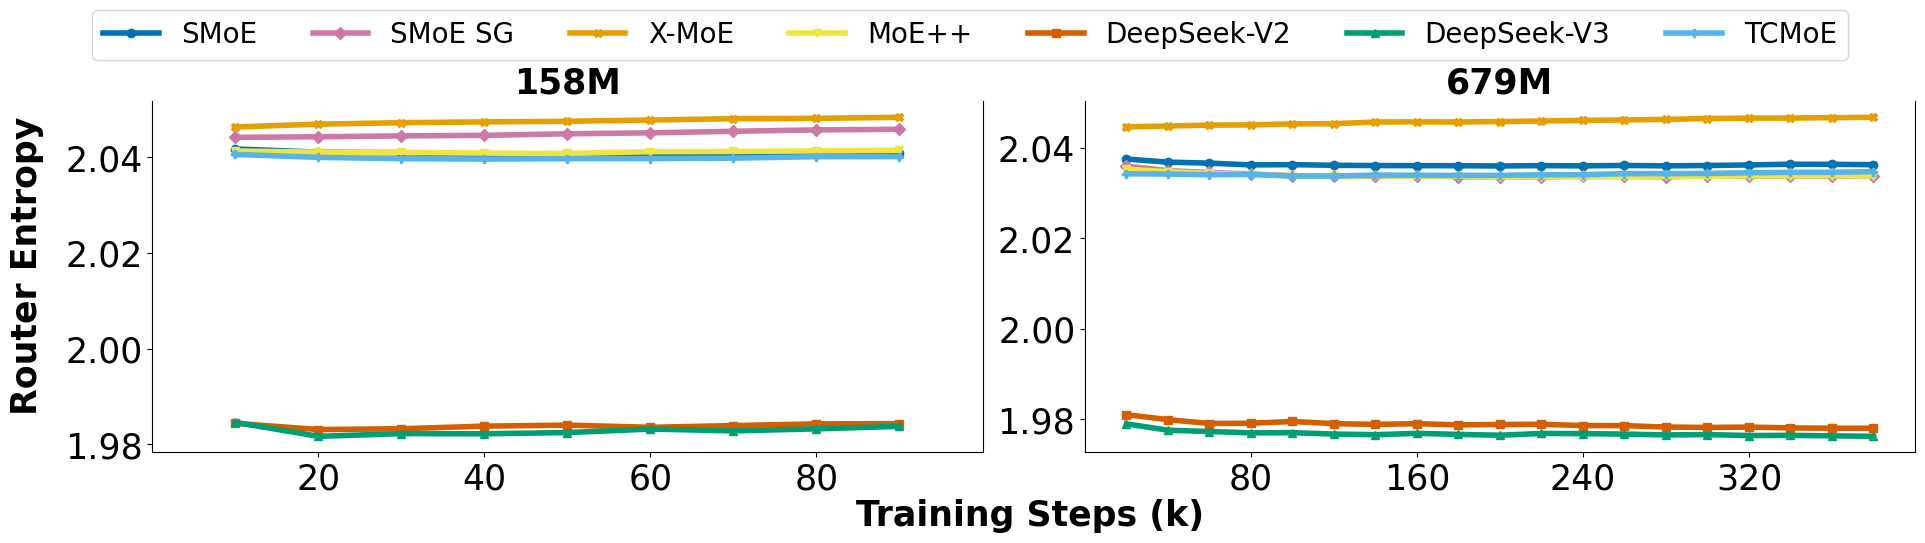

In [ ]:
cvd_palette = {
    "smoe": ("#0072B2", "o"), 
    "smoe_shared": ("#D55E00", "s"), 
    "smoe_deepseek": ("#009E73", "^"), 
    "moe_plus_plus": ("#F0E442", "v"),
    "smoe_sigmoid": ("#CC79A7", "D"), 
    "tcmoe": ("#56B4E9", "P"), 
    "xmoe": ("#E69F00", "X"),
}

fig, axs = plt.subplots(1, 2, figsize=(20, 5), sharex=False, sharey=False)

# Set shared labels
fig.text(0.55, 0.0, 'Training Steps (k)', ha='center', fontsize=25, weight='bold')
fig.text(0.04, 0.52, 'Router Entropy', va='center', rotation='vertical', fontsize=25, weight='bold')

xlims = [(0, 100), (0, 400)]
xticks = [np.arange(20, 100, 20)] * 1 + [np.arange(80, 400, 80)] * 1

# For legend collection
lines = []
labels = []

for i, ax in enumerate(axs):
    if i == 0:
        l1, = ax.plot(router_saturation_158m_top8["smoe"].index[:-1].astype(int) / 1000, router_saturation_158m_top8["smoe"].values[:-1], linewidth=4, color=cvd_palette["smoe"][0], marker=cvd_palette["smoe"][1], markersize=6)
        l2, = ax.plot(router_saturation_158m_top8["smoe_sigmoid"].index[:-1].astype(int) / 1000, router_saturation_158m_top8["smoe_sigmoid"].values[:-1], linewidth=4, color=cvd_palette["smoe_sigmoid"][0], marker=cvd_palette["smoe_sigmoid"][1], markersize=6)
        l3, = ax.plot(router_saturation_158m_top8["xmoe"].index[:-1].astype(int) / 1000, router_saturation_158m_top8["xmoe"].values[:-1], linewidth=4, color=cvd_palette["xmoe"][0], marker=cvd_palette["xmoe"][1], markersize=6)
        l4, = ax.plot(router_saturation_158m_top8["moe_plus_plus"].index[:-1].astype(int) / 1000, router_saturation_158m_top8["moe_plus_plus"].values[:-1], linewidth=4, color=cvd_palette["moe_plus_plus"][0], marker=cvd_palette["moe_plus_plus"][1], markersize=6)
        l5, = ax.plot(router_saturation_158m_top8["smoe_shared"].index[:-1].astype(int) / 1000, router_saturation_158m_top8["smoe_shared"].values[:-1], linewidth=4, color=cvd_palette["smoe_shared"][0], marker=cvd_palette["smoe_shared"][1], markersize=6)
        l6, = ax.plot(router_saturation_158m_top8["smoe_deepseek"].index[:-1].astype(int) / 1000, router_saturation_158m_top8["smoe_deepseek"].values[:-1], linewidth=4, color=cvd_palette["smoe_deepseek"][0], marker=cvd_palette["smoe_deepseek"][1], markersize=6)
        l7, = ax.plot(router_saturation_158m_top8["tcmoe"].index[:-1].astype(int) / 1000, router_saturation_158m_top8["tcmoe"].values[:-1], linewidth=4, color=cvd_palette["tcmoe"][0], marker=cvd_palette["tcmoe"][1], markersize=6)
        lines.extend([l1, l2, l3, l4, l5, l6, l7]) 
        labels.extend(["SMoE", "SMoE SG", "X-MoE", "MoE++", "DeepSeek-V2", "DeepSeek-V3", "TCMoE"])
        ax.set_title("158M", fontsize=25, weight='bold')
    elif i == 1:
        l1, = ax.plot(router_saturation_679m_top8["smoe"].index[:-1].astype(int) / 1000, router_saturation_679m_top8["smoe"].values[:-1], linewidth=4, color=cvd_palette["smoe"][0], marker=cvd_palette["smoe"][1], markersize=6)
        l2, = ax.plot(router_saturation_679m_top8["smoe_sigmoid"].index[:-1].astype(int) / 1000, router_saturation_679m_top8["smoe_sigmoid"].values[:-1], linewidth=4, color=cvd_palette["smoe_sigmoid"][0], marker=cvd_palette["smoe_sigmoid"][1], markersize=6)
        l3, = ax.plot(router_saturation_679m_top8["xmoe"].index[:-1].astype(int) / 1000, router_saturation_679m_top8["xmoe"].values[:-1], linewidth=4, color=cvd_palette["xmoe"][0], marker=cvd_palette["xmoe"][1], markersize=6)
        l4, = ax.plot(router_saturation_679m_top8["moe_plus_plus"].index[:-1].astype(int) / 1000, router_saturation_679m_top8["moe_plus_plus"].values[:-1], linewidth=4, color=cvd_palette["moe_plus_plus"][0], marker=cvd_palette["moe_plus_plus"][1], markersize=6)
        l5, = ax.plot(router_saturation_679m_top8["smoe_shared"].index[:-1].astype(int) / 1000, router_saturation_679m_top8["smoe_shared"].values[:-1], linewidth=4, color=cvd_palette["smoe_shared"][0], marker=cvd_palette["smoe_shared"][1], markersize=6)
        l6, = ax.plot(router_saturation_679m_top8["smoe_deepseek"].index[:-1].astype(int) / 1000, router_saturation_679m_top8["smoe_deepseek"].values[:-1], linewidth=4, color=cvd_palette["smoe_deepseek"][0], marker=cvd_palette["smoe_deepseek"][1], markersize=6)
        l7, = ax.plot(router_saturation_679m_top8["tcmoe"].index[:-1].astype(int) / 1000, router_saturation_679m_top8["tcmoe"].values[:-1], linewidth=4, color=cvd_palette["tcmoe"][0], marker=cvd_palette["tcmoe"][1], markersize=6)
        ax.set_title("679M", fontsize=25, weight='bold')
        
    ax.set_xticks(xticks[i])
    ax.set_xlim(xlims[i])
    
    ax.xaxis.set_tick_params(labelsize=25)
    ax.yaxis.set_tick_params(labelsize=25)
    
    # ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

# Create a global legend in the right
fig.legend(lines, labels, loc='upper center', ncol=7, fontsize=20, bbox_to_anchor=(0.52, 1.06))

# plt.tight_layout(rect=[0.06, 0.25, 1, 1.3])  # adjust bottom for legend space
plt.tight_layout(rect=[0.06, 0.03, 1, 0.95])  # leave top 8% blank
plt.savefig('/home/fpt/moeut_training_code/paper/deepseek/libmoe_fig/router_entropy.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Rourer Saturation

In [5]:
smoe_158m = router_saturation("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/smoe2", top_k=1).mean()
xmoe_158m = router_saturation("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/xmoe", top_k=1).mean()
smoe_sigmoid_158m = router_saturation("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/smoe_sigmoid", top_k=1).mean()
moe_plus_plus_158m = router_saturation("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/moe_plus_plus", top_k=1).mean()
smoe_shared_158m = router_saturation("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/smoe_shared", top_k=1).mean()
smoe_deepseek_158m = router_saturation("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/smoe_deepseek", top_k=1).mean()
smoe_tcmoe_158m = router_saturation("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/tcmoe", top_k=1).mean()

router_saturation_158m_top1 = {
    "smoe": smoe_158m,
    "xmoe": xmoe_158m,
    "smoe_sigmoid": smoe_sigmoid_158m,
    "moe_plus_plus": moe_plus_plus_158m,
    "smoe_shared": smoe_shared_158m,
    "smoe_deepseek": smoe_deepseek_158m,
    "tcmoe": smoe_tcmoe_158m,
}

In [6]:
smoe_158m = router_saturation("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/smoe2", top_k=8).mean()
xmoe_158m = router_saturation("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/xmoe", top_k=8).mean()
smoe_sigmoid_158m = router_saturation("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/smoe_sigmoid", top_k=8).mean()
moe_plus_plus_158m = router_saturation("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/moe_plus_plus", top_k=8).mean()
smoe_shared_158m = router_saturation("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/smoe_shared", top_k=8).mean()
smoe_deepseek_158m = router_saturation("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/smoe_deepseek", top_k=8).mean()
smoe_tcmoe_158m = router_saturation("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/tcmoe", top_k=8).mean()

router_saturation_158m_top8 = {
    "smoe": smoe_158m,
    "xmoe": xmoe_158m,
    "smoe_sigmoid": smoe_sigmoid_158m,
    "moe_plus_plus": moe_plus_plus_158m,
    "smoe_shared": smoe_shared_158m,
    "smoe_deepseek": smoe_deepseek_158m,
    "tcmoe": smoe_tcmoe_158m
}

In [8]:
smoe_679m = router_saturation("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/smoe", top_k=1).mean()
xmoe_679m = router_saturation("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/xmoe", top_k=1).mean()
smoe_sigmoid_679m = router_saturation("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/smoe_sigmoid", top_k=1).mean()
moe_plus_plus_679m = router_saturation("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/moe_plus_plus", top_k=1).mean()
smoe_shared_679m = router_saturation("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/smoe_shared", top_k=1).mean()
smoe_deepseek_679m = router_saturation("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/smoe_deepseek", top_k=1).mean()
smoe_tcmoe_679m = router_saturation("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/tcmoe", top_k=1).mean()

router_saturation_679m_top1 = {
    "smoe": smoe_679m,
    "xmoe": xmoe_679m,
    "smoe_sigmoid": smoe_sigmoid_679m,
    "moe_plus_plus": moe_plus_plus_679m,
    "smoe_shared": smoe_shared_679m,
    "smoe_deepseek": smoe_deepseek_679m,
    "tcmoe": smoe_tcmoe_679m,
}

In [9]:
smoe_679m = router_saturation("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/smoe", top_k=8).mean()
xmoe_679m = router_saturation("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/xmoe", top_k=8).mean()
smoe_sigmoid_679m = router_saturation("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/smoe_sigmoid", top_k=8).mean()
moe_plus_plus_679m = router_saturation("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/moe_plus_plus", top_k=8).mean()
smoe_shared_679m = router_saturation("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/smoe_shared", top_k=8).mean()
smoe_deepseek_679m = router_saturation("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/smoe_deepseek", top_k=8).mean()
smoe_tcmoe_679m = router_saturation("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/tcmoe", top_k=8).mean()

router_saturation_679m_top8 = {
    "smoe": smoe_679m,
    "xmoe": xmoe_679m,
    "smoe_sigmoid": smoe_sigmoid_679m,
    "moe_plus_plus": moe_plus_plus_679m,
    "smoe_shared": smoe_shared_679m,
    "smoe_deepseek": smoe_deepseek_679m,
    "tcmoe": smoe_tcmoe_679m
}

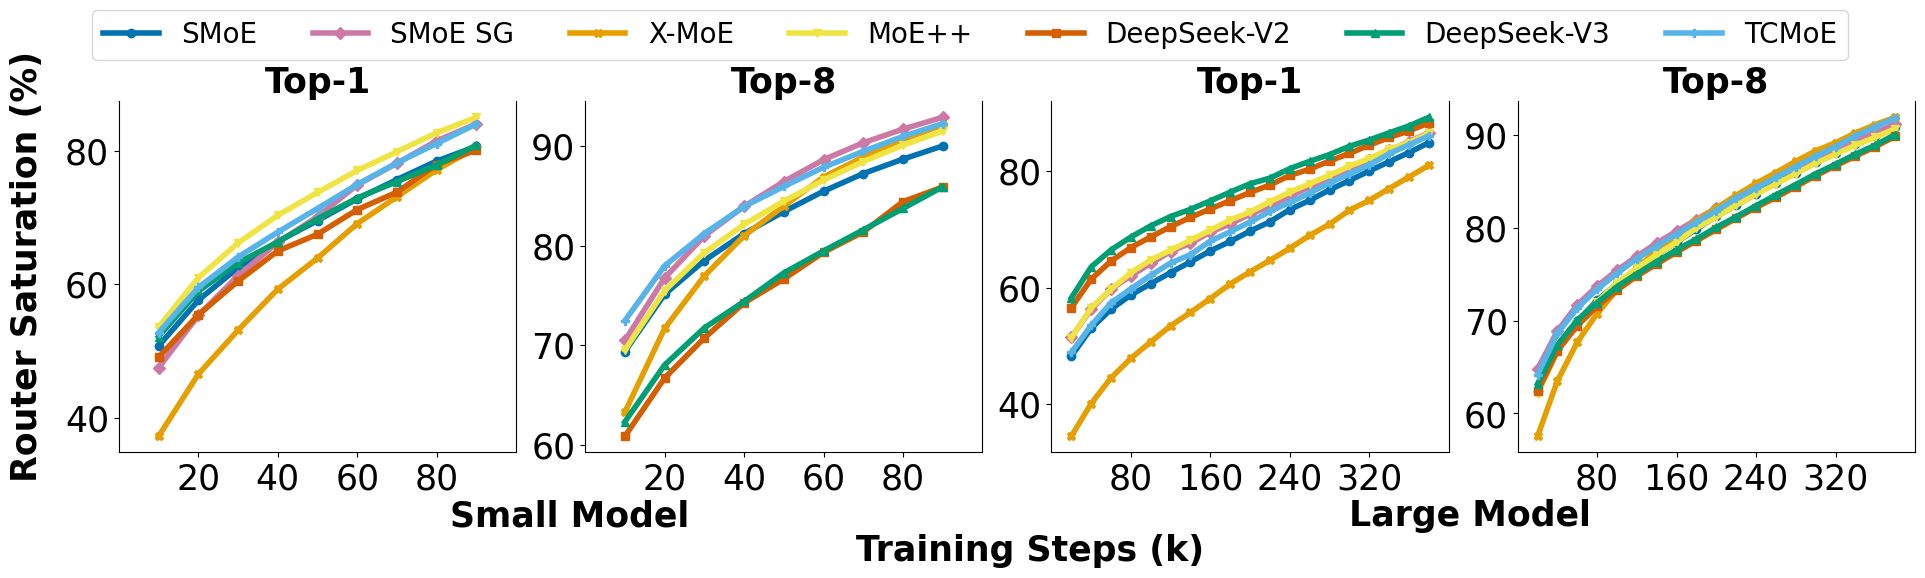

In [31]:
cvd_palette = {
    "smoe": ("#0072B2", "o"), 
    "smoe_shared": ("#D55E00", "s"), 
    "smoe_deepseek": ("#009E73", "^"), 
    "moe_plus_plus": ("#F0E442", "v"),
    "smoe_sigmoid": ("#CC79A7", "D"), 
    "tcmoe": ("#56B4E9", "P"), 
    "xmoe": ("#E69F00", "X"),
}

fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharex=False, sharey=False)

# Set shared labels
fig.text(0.55, -0.07, 'Training Steps (k)', ha='center', fontsize=25, weight='bold')
fig.text(0.04, 0.52, 'Router Saturation (%)', va='center', rotation='vertical', fontsize=25, weight='bold')

fig.text(0.32, 0., 'Small Model', ha='center', fontsize=25, weight='bold')
fig.text(0.77, 0., 'Large Model', ha='center', fontsize=25, weight='bold')


xlims = [(0, 100), (0, 100), (0, 400), (0, 400)]
xticks = [np.arange(20, 100, 20)] * 2 + [np.arange(80, 400, 80)] * 2

# For legend collection
lines = []
labels = []

for i, ax in enumerate(axs):
    if i == 0:
        l1, = ax.plot(router_saturation_158m_top1["smoe"].index[:-1].astype(int) / 1000, router_saturation_158m_top1["smoe"].values[:-1], linewidth=4, color=cvd_palette["smoe"][0], marker=cvd_palette["smoe"][1], markersize=6)
        l2, = ax.plot(router_saturation_158m_top1["smoe_sigmoid"].index[:-1].astype(int) / 1000, router_saturation_158m_top1["smoe_sigmoid"].values[:-1], linewidth=4, color=cvd_palette["smoe_sigmoid"][0], marker=cvd_palette["smoe_sigmoid"][1], markersize=6)
        l3, = ax.plot(router_saturation_158m_top1["xmoe"].index[:-1].astype(int) / 1000, router_saturation_158m_top1["xmoe"].values[:-1], linewidth=4, color=cvd_palette["xmoe"][0], marker=cvd_palette["xmoe"][1], markersize=6)
        l4, = ax.plot(router_saturation_158m_top1["moe_plus_plus"].index[:-1].astype(int) / 1000, router_saturation_158m_top1["moe_plus_plus"].values[:-1], linewidth=4, color=cvd_palette["moe_plus_plus"][0], marker=cvd_palette["moe_plus_plus"][1], markersize=6)
        l5, = ax.plot(router_saturation_158m_top1["smoe_shared"].index[:-1].astype(int) / 1000, router_saturation_158m_top1["smoe_shared"].values[:-1], linewidth=4, color=cvd_palette["smoe_shared"][0], marker=cvd_palette["smoe_shared"][1], markersize=6)
        l6, = ax.plot(router_saturation_158m_top1["smoe_deepseek"].index[:-1].astype(int) / 1000, router_saturation_158m_top1["smoe_deepseek"].values[:-1], linewidth=4, color=cvd_palette["smoe_deepseek"][0], marker=cvd_palette["smoe_deepseek"][1], markersize=6)
        l7, = ax.plot(router_saturation_158m_top1["tcmoe"].index[:-1].astype(int) / 1000, router_saturation_158m_top1["tcmoe"].values[:-1], linewidth=4, color=cvd_palette["tcmoe"][0], marker=cvd_palette["tcmoe"][1], markersize=6)
        lines.extend([l1, l2, l3, l4, l5, l6, l7]) 
        labels.extend(["SMoE", "SMoE SG", "X-MoE", "MoE++", "DeepSeek-V2", "DeepSeek-V3", "TCMoE"])
        ax.set_title("Top-1", fontsize=25, weight='bold')
    elif i == 1:
        l1, = ax.plot(router_saturation_158m_top8["smoe"].index[:-1].astype(int) / 1000, router_saturation_158m_top8["smoe"].values[:-1], linewidth=4, color=cvd_palette["smoe"][0], marker=cvd_palette["smoe"][1], markersize=6)
        l2, = ax.plot(router_saturation_158m_top8["smoe_sigmoid"].index[:-1].astype(int) / 1000, router_saturation_158m_top8["smoe_sigmoid"].values[:-1], linewidth=4, color=cvd_palette["smoe_sigmoid"][0], marker=cvd_palette["smoe_sigmoid"][1], markersize=6)
        l3, = ax.plot(router_saturation_158m_top8["xmoe"].index[:-1].astype(int) / 1000, router_saturation_158m_top8["xmoe"].values[:-1], linewidth=4, color=cvd_palette["xmoe"][0], marker=cvd_palette["xmoe"][1], markersize=6)
        l4, = ax.plot(router_saturation_158m_top8["moe_plus_plus"].index[:-1].astype(int) / 1000, router_saturation_158m_top8["moe_plus_plus"].values[:-1], linewidth=4, color=cvd_palette["moe_plus_plus"][0], marker=cvd_palette["moe_plus_plus"][1], markersize=6)
        l5, = ax.plot(router_saturation_158m_top8["smoe_shared"].index[:-1].astype(int) / 1000, router_saturation_158m_top8["smoe_shared"].values[:-1], linewidth=4, color=cvd_palette["smoe_shared"][0], marker=cvd_palette["smoe_shared"][1], markersize=6)
        l6, = ax.plot(router_saturation_158m_top8["smoe_deepseek"].index[:-1].astype(int) / 1000, router_saturation_158m_top8["smoe_deepseek"].values[:-1], linewidth=4, color=cvd_palette["smoe_deepseek"][0], marker=cvd_palette["smoe_deepseek"][1], markersize=6)
        l7, = ax.plot(router_saturation_158m_top8["tcmoe"].index[:-1].astype(int) / 1000, router_saturation_158m_top8["tcmoe"].values[:-1], linewidth=4, color=cvd_palette["tcmoe"][0], marker=cvd_palette["tcmoe"][1], markersize=6)
        ax.set_title("Top-8", fontsize=25, weight='bold')
    elif i == 2:
        l1, = ax.plot(router_saturation_679m_top1["smoe"].index[:-1].astype(int) / 1000, router_saturation_679m_top1["smoe"].values[:-1], linewidth=4, color=cvd_palette["smoe"][0], marker=cvd_palette["smoe"][1], markersize=6)
        l2, = ax.plot(router_saturation_679m_top1["smoe_sigmoid"].index[:-1].astype(int) / 1000, router_saturation_679m_top1["smoe_sigmoid"].values[:-1], linewidth=4, color=cvd_palette["smoe_sigmoid"][0], marker=cvd_palette["smoe_sigmoid"][1], markersize=6)
        l3, = ax.plot(router_saturation_679m_top1["xmoe"].index[:-1].astype(int) / 1000, router_saturation_679m_top1["xmoe"].values[:-1], linewidth=4, color=cvd_palette["xmoe"][0], marker=cvd_palette["xmoe"][1], markersize=6)
        l4, = ax.plot(router_saturation_679m_top1["moe_plus_plus"].index[:-1].astype(int) / 1000, router_saturation_679m_top1["moe_plus_plus"].values[:-1], linewidth=4, color=cvd_palette["moe_plus_plus"][0], marker=cvd_palette["moe_plus_plus"][1], markersize=6)
        l5, = ax.plot(router_saturation_679m_top1["smoe_shared"].index[:-1].astype(int) / 1000, router_saturation_679m_top1["smoe_shared"].values[:-1], linewidth=4, color=cvd_palette["smoe_shared"][0], marker=cvd_palette["smoe_shared"][1], markersize=6)
        l6, = ax.plot(router_saturation_679m_top1["smoe_deepseek"].index[:-1].astype(int) / 1000, router_saturation_679m_top1["smoe_deepseek"].values[:-1], linewidth=4, color=cvd_palette["smoe_deepseek"][0], marker=cvd_palette["smoe_deepseek"][1], markersize=6)
        l7, = ax.plot(router_saturation_679m_top1["tcmoe"].index[:-1].astype(int) / 1000, router_saturation_679m_top1["tcmoe"].values[:-1], linewidth=4, color=cvd_palette["tcmoe"][0], marker=cvd_palette["tcmoe"][1], markersize=6)
        ax.set_title("Top-1", fontsize=25, weight='bold')
    elif i == 3:
        l1, = ax.plot(router_saturation_679m_top8["smoe"].index[:-1].astype(int) / 1000, router_saturation_679m_top8["smoe"].values[:-1], linewidth=4, color=cvd_palette["smoe"][0], marker=cvd_palette["smoe"][1], markersize=6)
        l2, = ax.plot(router_saturation_679m_top8["smoe_sigmoid"].index[:-1].astype(int) / 1000, router_saturation_679m_top8["smoe_sigmoid"].values[:-1], linewidth=4, color=cvd_palette["smoe_sigmoid"][0], marker=cvd_palette["smoe_sigmoid"][1], markersize=6)
        l3, = ax.plot(router_saturation_679m_top8["xmoe"].index[:-1].astype(int) / 1000, router_saturation_679m_top8["xmoe"].values[:-1], linewidth=4, color=cvd_palette["xmoe"][0], marker=cvd_palette["xmoe"][1], markersize=6)
        l4, = ax.plot(router_saturation_679m_top8["moe_plus_plus"].index[:-1].astype(int) / 1000, router_saturation_679m_top8["moe_plus_plus"].values[:-1], linewidth=4, color=cvd_palette["moe_plus_plus"][0], marker=cvd_palette["moe_plus_plus"][1], markersize=6)
        l5, = ax.plot(router_saturation_679m_top8["smoe_shared"].index[:-1].astype(int) / 1000, router_saturation_679m_top8["smoe_shared"].values[:-1], linewidth=4, color=cvd_palette["smoe_shared"][0], marker=cvd_palette["smoe_shared"][1], markersize=6)
        l6, = ax.plot(router_saturation_679m_top8["smoe_deepseek"].index[:-1].astype(int) / 1000, router_saturation_679m_top8["smoe_deepseek"].values[:-1], linewidth=4, color=cvd_palette["smoe_deepseek"][0], marker=cvd_palette["smoe_deepseek"][1], markersize=6)
        l7, = ax.plot(router_saturation_679m_top8["tcmoe"].index[:-1].astype(int) / 1000, router_saturation_679m_top8["tcmoe"].values[:-1], linewidth=4, color=cvd_palette["tcmoe"][0], marker=cvd_palette["tcmoe"][1], markersize=6)
        ax.set_title("Top-8", fontsize=25, weight='bold')
        
    ax.set_xticks(xticks[i])
    ax.set_xlim(xlims[i])
    
    ax.xaxis.set_tick_params(labelsize=25)
    ax.yaxis.set_tick_params(labelsize=25)
    
    # ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

# Create a global legend in the right
fig.legend(lines, labels, loc='upper center', ncol=7, fontsize=20, bbox_to_anchor=(0.52, 1.06))

# plt.tight_layout(rect=[0.06, 0.25, 1, 1.3])  # adjust bottom for legend space
plt.tight_layout(rect=[0.06, 0.03, 1, 0.95])  # leave top 8% blank
plt.savefig('/home/fpt/moeut_training_code/paper/deepseek/libmoe_fig/router_saturation.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Router Change Rate

In [39]:
smoe_158m = router_change_rate("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/smoe2", top_k=1).mean()
xmoe_158m = router_change_rate("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/xmoe", top_k=1).mean()
smoe_sigmoid_158m = router_change_rate("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/smoe_sigmoid", top_k=1).mean()
moe_plus_plus_158m = router_change_rate("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/moe_plus_plus", top_k=1).mean()
smoe_shared_158m = router_change_rate("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/smoe_shared", top_k=1).mean()
smoe_deepseek_158m = router_change_rate("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/smoe_deepseek", top_k=1).mean()
smoe_tcmoe_158m = router_change_rate("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/tcmoe", top_k=1).mean()

router_change_rate_158m_top1 = {
    "smoe": smoe_158m,
    "xmoe": xmoe_158m,
    "smoe_sigmoid": smoe_sigmoid_158m,
    "moe_plus_plus": moe_plus_plus_158m,
    "smoe_shared": smoe_shared_158m,
    "smoe_deepseek": smoe_deepseek_158m,
    "tcmoe": smoe_tcmoe_158m,
}

In [40]:
smoe_158m = router_change_rate("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/smoe2", top_k=8).mean()
xmoe_158m = router_change_rate("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/xmoe", top_k=8).mean()
smoe_sigmoid_158m = router_change_rate("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/smoe_sigmoid", top_k=8).mean()
moe_plus_plus_158m = router_change_rate("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/moe_plus_plus", top_k=8).mean()
smoe_shared_158m = router_change_rate("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/smoe_shared", top_k=8).mean()
smoe_deepseek_158m = router_change_rate("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/smoe_deepseek", top_k=8).mean()
smoe_tcmoe_158m = router_change_rate("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/tcmoe", top_k=8).mean()

router_change_rate_158m_top8 = {
    "smoe": smoe_158m,
    "xmoe": xmoe_158m,
    "smoe_sigmoid": smoe_sigmoid_158m,
    "moe_plus_plus": moe_plus_plus_158m,
    "smoe_shared": smoe_shared_158m,
    "smoe_deepseek": smoe_deepseek_158m,
    "tcmoe": smoe_tcmoe_158m
}

In [41]:
smoe_679m = router_change_rate("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/smoe", top_k=1).mean()
xmoe_679m = router_change_rate("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/xmoe", top_k=1).mean()
smoe_sigmoid_679m = router_change_rate("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/smoe_sigmoid", top_k=1).mean()
moe_plus_plus_679m = router_change_rate("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/moe_plus_plus", top_k=1).mean()
smoe_shared_679m = router_change_rate("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/smoe_shared", top_k=1).mean()
smoe_deepseek_679m = router_change_rate("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/smoe_deepseek", top_k=1).mean()
smoe_tcmoe_679m = router_change_rate("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/tcmoe", top_k=1).mean()

router_change_rate_679m_top1 = {
    "smoe": smoe_679m,
    "xmoe": xmoe_679m,
    "smoe_sigmoid": smoe_sigmoid_679m,
    "moe_plus_plus": moe_plus_plus_679m,
    "smoe_shared": smoe_shared_679m,
    "smoe_deepseek": smoe_deepseek_679m,
    "tcmoe": smoe_tcmoe_679m,
}

In [42]:
smoe_679m = router_change_rate("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/smoe", top_k=8).mean()
xmoe_679m = router_change_rate("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/xmoe", top_k=8).mean()
smoe_sigmoid_679m = router_change_rate("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/smoe_sigmoid", top_k=8).mean()
moe_plus_plus_679m = router_change_rate("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/moe_plus_plus", top_k=8).mean()
smoe_shared_679m = router_change_rate("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/smoe_shared", top_k=8).mean()
smoe_deepseek_679m = router_change_rate("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/smoe_deepseek", top_k=8).mean()
smoe_tcmoe_679m = router_change_rate("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/tcmoe", top_k=8).mean()

router_change_rate_679m_top8 = {
    "smoe": smoe_679m,
    "xmoe": xmoe_679m,
    "smoe_sigmoid": smoe_sigmoid_679m,
    "moe_plus_plus": moe_plus_plus_679m,
    "smoe_shared": smoe_shared_679m,
    "smoe_deepseek": smoe_deepseek_679m,
    "tcmoe": smoe_tcmoe_679m
}

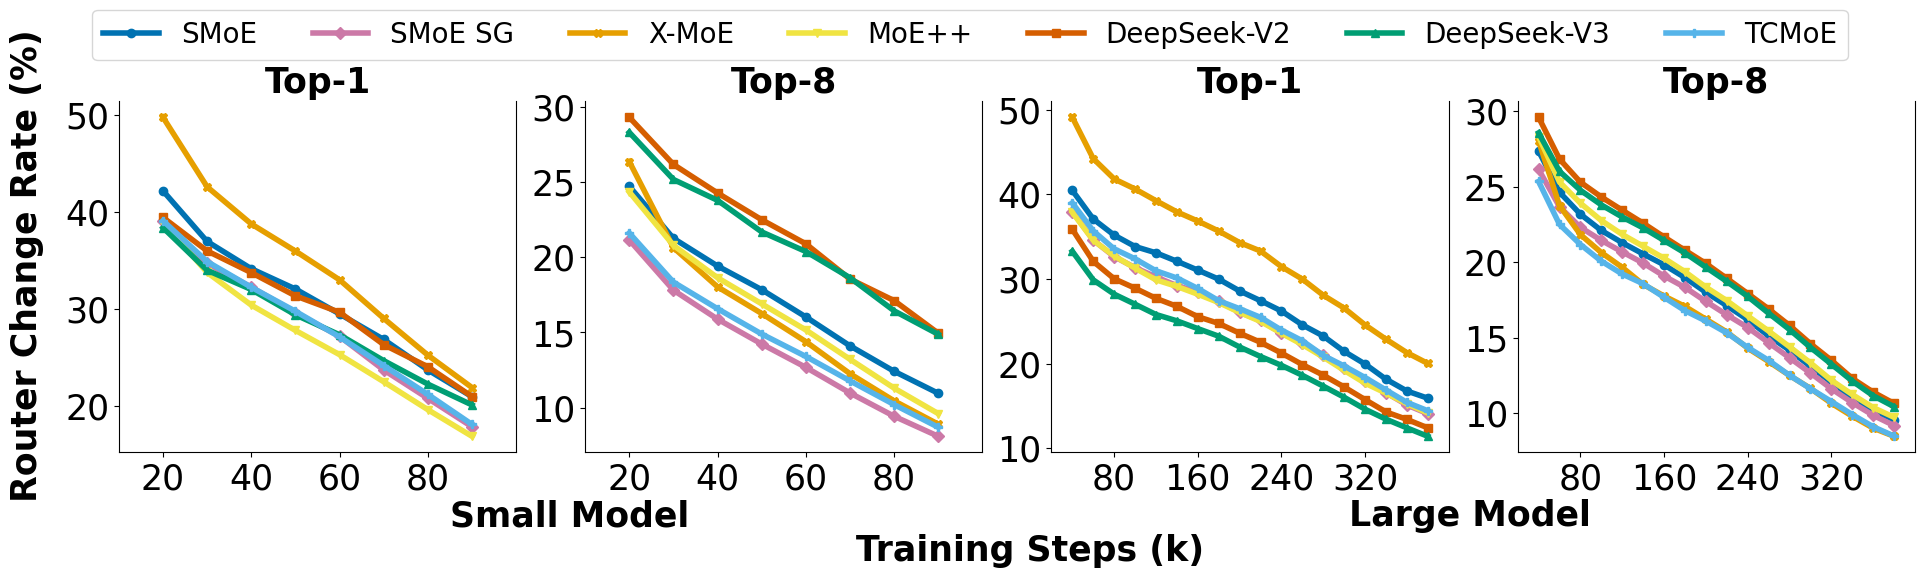

In [47]:
cvd_palette = {
    "smoe": ("#0072B2", "o"), 
    "smoe_shared": ("#D55E00", "s"), 
    "smoe_deepseek": ("#009E73", "^"), 
    "moe_plus_plus": ("#F0E442", "v"),
    "smoe_sigmoid": ("#CC79A7", "D"), 
    "tcmoe": ("#56B4E9", "P"), 
    "xmoe": ("#E69F00", "X"),
}

fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharex=False, sharey=False)

# Set shared labels
fig.text(0.55, -0.07, 'Training Steps (k)', ha='center', fontsize=25, weight='bold')
fig.text(0.04, 0.52, 'Router Change Rate (%)', va='center', rotation='vertical', fontsize=25, weight='bold')

fig.text(0.32, 0., 'Small Model', ha='center', fontsize=25, weight='bold')
fig.text(0.77, 0., 'Large Model', ha='center', fontsize=25, weight='bold')


xlims = [(10, 100), (10, 100), (20, 400), (20, 400)]
xticks = [np.arange(20, 100, 20)] * 2 + [np.arange(80, 400, 80)] * 2

# For legend collection
lines = []
labels = []

for i, ax in enumerate(axs):
    if i == 0:
        l1, = ax.plot(router_change_rate_158m_top1["smoe"].index[:-1].astype(int) / 1000, router_change_rate_158m_top1["smoe"].values[:-1], linewidth=4, color=cvd_palette["smoe"][0], marker=cvd_palette["smoe"][1], markersize=6)
        l2, = ax.plot(router_change_rate_158m_top1["smoe_sigmoid"].index[:-1].astype(int) / 1000, router_change_rate_158m_top1["smoe_sigmoid"].values[:-1], linewidth=4, color=cvd_palette["smoe_sigmoid"][0], marker=cvd_palette["smoe_sigmoid"][1], markersize=6)
        l3, = ax.plot(router_change_rate_158m_top1["xmoe"].index[:-1].astype(int) / 1000, router_change_rate_158m_top1["xmoe"].values[:-1], linewidth=4, color=cvd_palette["xmoe"][0], marker=cvd_palette["xmoe"][1], markersize=6)
        l4, = ax.plot(router_change_rate_158m_top1["moe_plus_plus"].index[:-1].astype(int) / 1000, router_change_rate_158m_top1["moe_plus_plus"].values[:-1], linewidth=4, color=cvd_palette["moe_plus_plus"][0], marker=cvd_palette["moe_plus_plus"][1], markersize=6)
        l5, = ax.plot(router_change_rate_158m_top1["smoe_shared"].index[:-1].astype(int) / 1000, router_change_rate_158m_top1["smoe_shared"].values[:-1], linewidth=4, color=cvd_palette["smoe_shared"][0], marker=cvd_palette["smoe_shared"][1], markersize=6)
        l6, = ax.plot(router_change_rate_158m_top1["smoe_deepseek"].index[:-1].astype(int) / 1000, router_change_rate_158m_top1["smoe_deepseek"].values[:-1], linewidth=4, color=cvd_palette["smoe_deepseek"][0], marker=cvd_palette["smoe_deepseek"][1], markersize=6)
        l7, = ax.plot(router_change_rate_158m_top1["tcmoe"].index[:-1].astype(int) / 1000, router_change_rate_158m_top1["tcmoe"].values[:-1], linewidth=4, color=cvd_palette["tcmoe"][0], marker=cvd_palette["tcmoe"][1], markersize=6)
        lines.extend([l1, l2, l3, l4, l5, l6, l7]) 
        labels.extend(["SMoE", "SMoE SG", "X-MoE", "MoE++", "DeepSeek-V2", "DeepSeek-V3", "TCMoE"])
        ax.set_title("Top-1", fontsize=25, weight='bold')
    elif i == 1:
        l1, = ax.plot(router_change_rate_158m_top8["smoe"].index[:-1].astype(int) / 1000, router_change_rate_158m_top8["smoe"].values[:-1], linewidth=4, color=cvd_palette["smoe"][0], marker=cvd_palette["smoe"][1], markersize=6)
        l2, = ax.plot(router_change_rate_158m_top8["smoe_sigmoid"].index[:-1].astype(int) / 1000, router_change_rate_158m_top8["smoe_sigmoid"].values[:-1], linewidth=4, color=cvd_palette["smoe_sigmoid"][0], marker=cvd_palette["smoe_sigmoid"][1], markersize=6)
        l3, = ax.plot(router_change_rate_158m_top8["xmoe"].index[:-1].astype(int) / 1000, router_change_rate_158m_top8["xmoe"].values[:-1], linewidth=4, color=cvd_palette["xmoe"][0], marker=cvd_palette["xmoe"][1], markersize=6)
        l4, = ax.plot(router_change_rate_158m_top8["moe_plus_plus"].index[:-1].astype(int) / 1000, router_change_rate_158m_top8["moe_plus_plus"].values[:-1], linewidth=4, color=cvd_palette["moe_plus_plus"][0], marker=cvd_palette["moe_plus_plus"][1], markersize=6)
        l5, = ax.plot(router_change_rate_158m_top8["smoe_shared"].index[:-1].astype(int) / 1000, router_change_rate_158m_top8["smoe_shared"].values[:-1], linewidth=4, color=cvd_palette["smoe_shared"][0], marker=cvd_palette["smoe_shared"][1], markersize=6)
        l6, = ax.plot(router_change_rate_158m_top8["smoe_deepseek"].index[:-1].astype(int) / 1000, router_change_rate_158m_top8["smoe_deepseek"].values[:-1], linewidth=4, color=cvd_palette["smoe_deepseek"][0], marker=cvd_palette["smoe_deepseek"][1], markersize=6)
        l7, = ax.plot(router_change_rate_158m_top8["tcmoe"].index[:-1].astype(int) / 1000, router_change_rate_158m_top8["tcmoe"].values[:-1], linewidth=4, color=cvd_palette["tcmoe"][0], marker=cvd_palette["tcmoe"][1], markersize=6)
        ax.set_title("Top-8", fontsize=25, weight='bold')
    elif i == 2:
        l1, = ax.plot(router_change_rate_679m_top1["smoe"].index[:-1].astype(int) / 1000, router_change_rate_679m_top1["smoe"].values[:-1], linewidth=4, color=cvd_palette["smoe"][0], marker=cvd_palette["smoe"][1], markersize=6)
        l2, = ax.plot(router_change_rate_679m_top1["smoe_sigmoid"].index[:-1].astype(int) / 1000, router_change_rate_679m_top1["smoe_sigmoid"].values[:-1], linewidth=4, color=cvd_palette["smoe_sigmoid"][0], marker=cvd_palette["smoe_sigmoid"][1], markersize=6)
        l3, = ax.plot(router_change_rate_679m_top1["xmoe"].index[:-1].astype(int) / 1000, router_change_rate_679m_top1["xmoe"].values[:-1], linewidth=4, color=cvd_palette["xmoe"][0], marker=cvd_palette["xmoe"][1], markersize=6)
        l4, = ax.plot(router_change_rate_679m_top1["moe_plus_plus"].index[:-1].astype(int) / 1000, router_change_rate_679m_top1["moe_plus_plus"].values[:-1], linewidth=4, color=cvd_palette["moe_plus_plus"][0], marker=cvd_palette["moe_plus_plus"][1], markersize=6)
        l5, = ax.plot(router_change_rate_679m_top1["smoe_shared"].index[:-1].astype(int) / 1000, router_change_rate_679m_top1["smoe_shared"].values[:-1], linewidth=4, color=cvd_palette["smoe_shared"][0], marker=cvd_palette["smoe_shared"][1], markersize=6)
        l6, = ax.plot(router_change_rate_679m_top1["smoe_deepseek"].index[:-1].astype(int) / 1000, router_change_rate_679m_top1["smoe_deepseek"].values[:-1], linewidth=4, color=cvd_palette["smoe_deepseek"][0], marker=cvd_palette["smoe_deepseek"][1], markersize=6)
        l7, = ax.plot(router_change_rate_679m_top1["tcmoe"].index[:-1].astype(int) / 1000, router_change_rate_679m_top1["tcmoe"].values[:-1], linewidth=4, color=cvd_palette["tcmoe"][0], marker=cvd_palette["tcmoe"][1], markersize=6)
        ax.set_title("Top-1", fontsize=25, weight='bold')
    elif i == 3:
        l1, = ax.plot(router_change_rate_679m_top8["smoe"].index[:-1].astype(int) / 1000, router_change_rate_679m_top8["smoe"].values[:-1], linewidth=4, color=cvd_palette["smoe"][0], marker=cvd_palette["smoe"][1], markersize=6)
        l2, = ax.plot(router_change_rate_679m_top8["smoe_sigmoid"].index[:-1].astype(int) / 1000, router_change_rate_679m_top8["smoe_sigmoid"].values[:-1], linewidth=4, color=cvd_palette["smoe_sigmoid"][0], marker=cvd_palette["smoe_sigmoid"][1], markersize=6)
        l3, = ax.plot(router_change_rate_679m_top8["xmoe"].index[:-1].astype(int) / 1000, router_change_rate_679m_top8["xmoe"].values[:-1], linewidth=4, color=cvd_palette["xmoe"][0], marker=cvd_palette["xmoe"][1], markersize=6)
        l4, = ax.plot(router_change_rate_679m_top8["moe_plus_plus"].index[:-1].astype(int) / 1000, router_change_rate_679m_top8["moe_plus_plus"].values[:-1], linewidth=4, color=cvd_palette["moe_plus_plus"][0], marker=cvd_palette["moe_plus_plus"][1], markersize=6)
        l5, = ax.plot(router_change_rate_679m_top8["smoe_shared"].index[:-1].astype(int) / 1000, router_change_rate_679m_top8["smoe_shared"].values[:-1], linewidth=4, color=cvd_palette["smoe_shared"][0], marker=cvd_palette["smoe_shared"][1], markersize=6)
        l6, = ax.plot(router_change_rate_679m_top8["smoe_deepseek"].index[:-1].astype(int) / 1000, router_change_rate_679m_top8["smoe_deepseek"].values[:-1], linewidth=4, color=cvd_palette["smoe_deepseek"][0], marker=cvd_palette["smoe_deepseek"][1], markersize=6)
        l7, = ax.plot(router_change_rate_679m_top8["tcmoe"].index[:-1].astype(int) / 1000, router_change_rate_679m_top8["tcmoe"].values[:-1], linewidth=4, color=cvd_palette["tcmoe"][0], marker=cvd_palette["tcmoe"][1], markersize=6)
        ax.set_title("Top-8", fontsize=25, weight='bold')
        
    ax.set_xticks(xticks[i])
    ax.set_xlim(xlims[i])
    
    ax.xaxis.set_tick_params(labelsize=25)
    ax.yaxis.set_tick_params(labelsize=25)
    
    # ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

# Create a global legend in the right
fig.legend(lines, labels, loc='upper center', ncol=7, fontsize=20, bbox_to_anchor=(0.52, 1.06))

# plt.tight_layout(rect=[0.06, 0.25, 1, 1.3])  # adjust bottom for legend space
plt.tight_layout(rect=[0.06, 0.03, 1, 0.95])  # leave top 8% blank
plt.savefig('/home/fpt/moeut_training_code/paper/deepseek/libmoe_fig/router_change_rate.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Load Balancing

### 159M

In [19]:
logits_nolb, _ = top_k_numpy(np.load("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/smoe_nolb/model-100000.npy"), top_k=8, dim=-1)
logits_lb, _ = top_k_numpy(np.load("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/smoe/model-100000.npy"), top_k=8, dim=-1)
logits_zloss, _ = top_k_numpy(np.load("/home/fpt/moeut_training_code/paper/deepseek/logits/158M/smoe_zloss/model-100000.npy"), top_k=8, dim=-1)
# logits_nolb, logit_lb = logits_nolb[:, :6000, :], logits_lb[:, :6000, :]

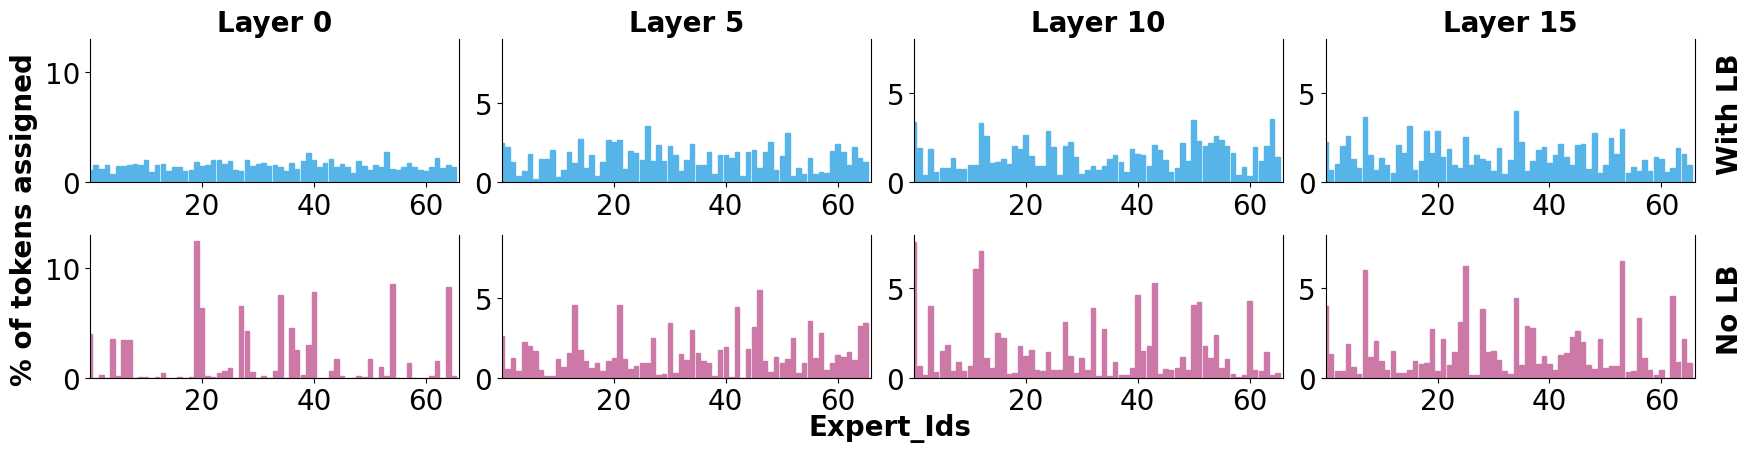

In [39]:
cvd_palette = {
    "smoe": ("#0072B2", "o"), 
    "smoe_shared": ("#D55E00", "s"), 
    "smoe_deepseek": ("#009E73", "^"), 
    "moe_plus_plus": ("#F0E442", "v"),
    "smoe_sigmoid": ("#CC79A7", "D"), 
    "tcmoe": ("#56B4E9", "P"), 
    "xmoe": ("#E69F00", "X"),
}

fig, axs = plt.subplots(2, 4, figsize=(20, 4.5), sharex=False, sharey=False)

# Set shared labels
fig.text(0.48, 0.02, 'Expert_Ids', ha='center', fontsize=20, weight='bold')
fig.text(0.04, 0.5, '% of tokens assigned', va='center', rotation='vertical', fontsize=20, weight='bold')

fig.text(0.90, 0.6, 'With LB', ha='center', va='bottom', fontsize=20, rotation='vertical', weight='bold')
fig.text(0.90, 0.2, 'No LB', ha='center', va='bottom', fontsize=20, rotation='vertical', weight='bold')


xlims = [(0, 66), (0, 66)]
xticks = [np.arange(20, 100, 20)] * 2

# For legend collection
lines = []
labels = []
layer = [0, 5, 10, 15]

for i, ax in enumerate(axs):
    if i == 0:
        # plt.bar(range(66), 100 * logits_lb.sum(0).sum(0) / logits_lb.sum())
        ax[0].bar(range(66), 100 * logits_lb[layer[0]].sum(0) / logits_lb[layer[0]].sum(), color=cvd_palette["tcmoe"][0], edgecolor=cvd_palette["tcmoe"][0])
        ax[1].bar(range(66), 100 * logits_lb[layer[1]].sum(0) / logits_lb[layer[1]].sum(), color=cvd_palette["tcmoe"][0], edgecolor=cvd_palette["tcmoe"][0])
        ax[2].bar(range(66), 100 * logits_lb[layer[2]].sum(0) / logits_lb[layer[2]].sum(), color=cvd_palette["tcmoe"][0], edgecolor=cvd_palette["tcmoe"][0])
        ax[3].bar(range(66), 100 * logits_lb[layer[3]].sum(0) / logits_lb[layer[3]].sum(), color=cvd_palette["tcmoe"][0], edgecolor=cvd_palette["tcmoe"][0])
        
        ax[0].set_title(f"Layer {layer[0]}", fontsize=20, weight='bold')
        ax[1].set_title(f"Layer {layer[1]}", fontsize=20, weight='bold')
        ax[2].set_title(f"Layer {layer[2]}", fontsize=20, weight='bold')
        ax[3].set_title(f"Layer {layer[3]}", fontsize=20, weight='bold')
    elif i == 1:
        ax[0].bar(range(66), 100 * logits_nolb[layer[0]].sum(0) / logits_nolb[layer[0]].sum(), color=cvd_palette["smoe_sigmoid"][0], edgecolor=cvd_palette["smoe_sigmoid"][0])
        ax[1].bar(range(66), 100 * logits_nolb[layer[1]].sum(0) / logits_nolb[layer[1]].sum(), color=cvd_palette["smoe_sigmoid"][0], edgecolor=cvd_palette["smoe_sigmoid"][0])
        ax[2].bar(range(66), 100 * logits_nolb[layer[2]].sum(0) / logits_nolb[layer[2]].sum(), color=cvd_palette["smoe_sigmoid"][0], edgecolor=cvd_palette["smoe_sigmoid"][0])
        ax[3].bar(range(66), 100 * logits_nolb[layer[3]].sum(0) / logits_nolb[layer[3]].sum(), color=cvd_palette["smoe_sigmoid"][0], edgecolor=cvd_palette["smoe_sigmoid"][0])
        
    ax[0].set_xticks(xticks[i])
    ax[0].set_xlim(xlims[i])
    ax[0].set_ylim([0, 13])
    
    ax[1].set_xticks(xticks[i])
    ax[1].set_xlim(xlims[i])
    ax[1].set_ylim([0, 9])
    
    ax[2].set_xticks(xticks[i])
    ax[2].set_xlim(xlims[i])
    ax[2].set_ylim([0, 8])
    
    ax[3].set_xticks(xticks[i])
    ax[3].set_xlim(xlims[i])
    ax[3].set_ylim([0, 8])
    
    for i in range(4):
        ax[i].xaxis.set_tick_params(labelsize=20)
        ax[i].yaxis.set_tick_params(labelsize=20)
        # ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)

# Create a global legend in the right
# fig.legend(lines, labels, loc='upper center', ncol=4, fontsize=20, bbox_to_anchor=(0.55, 1.06))

# plt.tight_layout(rect=[0.06, 0.25, 1, 1.3])  # adjust bottom for legend space
plt.tight_layout(rect=[0.05, 0.03, 0.89, 1.])  # leave top 8% blank
plt.savefig('/home/fpt/moeut_training_code/paper/deepseek/libmoe_fig/load_balancing_dis.pdf', format='pdf', bbox_inches='tight')
plt.show()

### 679M

In [15]:
logits_nolb, _ = top_k_numpy(np.load("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/smoe_nolb/model-400000.npy"), top_k=8, dim=-1)
logits_lb, _ = top_k_numpy(np.load("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/smoe/model-400000.npy"), top_k=8, dim=-1)

# logits_nolb, logit_lb = logits_nolb[:, :6000, :], logits_lb[:, :6000, :]

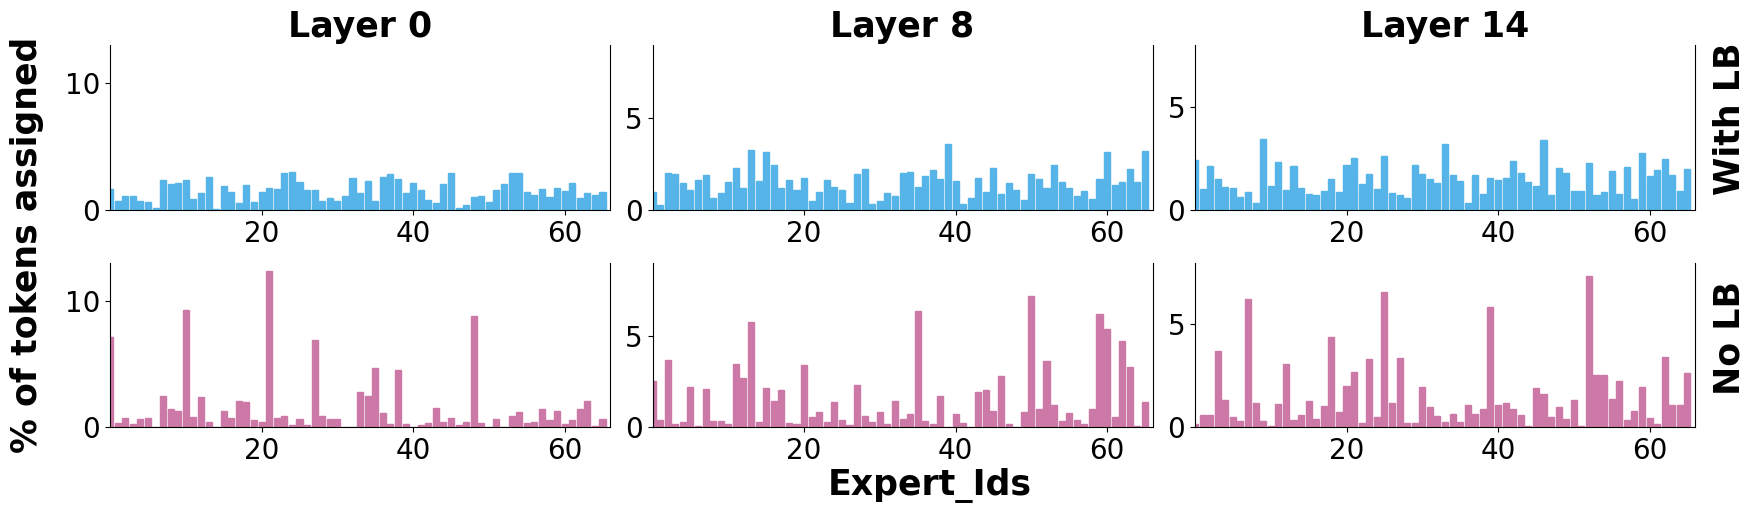

In [16]:
cvd_palette = {
    "smoe": ("#0072B2", "o"), 
    "smoe_shared": ("#D55E00", "s"), 
    "smoe_deepseek": ("#009E73", "^"), 
    "moe_plus_plus": ("#F0E442", "v"),
    "smoe_sigmoid": ("#CC79A7", "D"), 
    "tcmoe": ("#56B4E9", "P"), 
    "xmoe": ("#E69F00", "X"),
}

fig, axs = plt.subplots(2, 3, figsize=(20, 5), sharex=False, sharey=False)

# Set shared labels
fig.text(0.5, 0., 'Expert_Ids', ha='center', fontsize=25, weight='bold')
fig.text(0.04, 0.5, '% of tokens assigned', va='center', rotation='vertical', fontsize=25, weight='bold')

fig.text(0.90, 0.6, 'With LB', ha='center', va='bottom', fontsize=25, rotation='vertical', weight='bold')
fig.text(0.90, 0.2, 'No LB', ha='center', va='bottom', fontsize=25, rotation='vertical', weight='bold')


xlims = [(0, 66), (0, 66)]
xticks = [np.arange(20, 100, 20)] * 2

# For legend collection
lines = []
labels = []
layer = [0, 8, 14]

for i, ax in enumerate(axs):
    if i == 0:
        # plt.bar(range(66), 100 * logits_lb.sum(0).sum(0) / logits_lb.sum())
        ax[0].bar(range(66), 100 * logits_lb[layer[0]].sum(0) / logits_lb[layer[0]].sum(), color=cvd_palette["tcmoe"][0], edgecolor=cvd_palette["tcmoe"][0])
        ax[1].bar(range(66), 100 * logits_lb[layer[1]].sum(0) / logits_lb[layer[1]].sum(), color=cvd_palette["tcmoe"][0], edgecolor=cvd_palette["tcmoe"][0])
        ax[2].bar(range(66), 100 * logits_lb[layer[2]].sum(0) / logits_lb[layer[2]].sum(), color=cvd_palette["tcmoe"][0], edgecolor=cvd_palette["tcmoe"][0])
        
        ax[0].set_title(f"Layer {layer[0]}", fontsize=25, weight='bold')
        ax[1].set_title(f"Layer {layer[1]}", fontsize=25, weight='bold')
        ax[2].set_title(f"Layer {layer[2]}", fontsize=25, weight='bold')
        
    elif i == 1:
        ax[0].bar(range(66), 100 * logits_nolb[layer[0]].sum(0) / logits_nolb[layer[0]].sum(), color=cvd_palette["smoe_sigmoid"][0], edgecolor=cvd_palette["smoe_sigmoid"][0])
        ax[1].bar(range(66), 100 * logits_nolb[layer[1]].sum(0) / logits_nolb[layer[1]].sum(), color=cvd_palette["smoe_sigmoid"][0], edgecolor=cvd_palette["smoe_sigmoid"][0])
        ax[2].bar(range(66), 100 * logits_nolb[layer[2]].sum(0) / logits_nolb[layer[2]].sum(), color=cvd_palette["smoe_sigmoid"][0], edgecolor=cvd_palette["smoe_sigmoid"][0])
        
    ax[0].set_xticks(xticks[i])
    ax[0].set_xlim(xlims[i])
    ax[0].set_ylim([0, 13])
    
    ax[1].set_xticks(xticks[i])
    ax[1].set_xlim(xlims[i])
    ax[1].set_ylim([0, 9])
    
    ax[2].set_xticks(xticks[i])
    ax[2].set_xlim(xlims[i])
    ax[2].set_ylim([0, 8])
    
    for i in range(3):
        ax[i].xaxis.set_tick_params(labelsize=20)
        ax[i].yaxis.set_tick_params(labelsize=20)
        # ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)

# Create a global legend in the right
# fig.legend(lines, labels, loc='upper center', ncol=4, fontsize=20, bbox_to_anchor=(0.55, 1.06))

# plt.tight_layout(rect=[0.06, 0.25, 1, 1.3])  # adjust bottom for legend space
plt.tight_layout(rect=[0.06, 0.03, 0.89, 1.])  # leave top 8% blank
plt.savefig('/home/fpt/moeut_training_code/paper/deepseek/libmoe_fig/load_balancing_dis_679M.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

### 159M

In [ ]:
event_smoe = EventAccumulator('/home/fpt/moeut_training_code/tensorboard/158m/smoe/tensorboard')
event_smoe.Reload()  # Load the events
event_smoe_nolb = EventAccumulator('/home/fpt/moeut_training_code/tensorboard/158m/smoe_nolb/tensorboard')
event_smoe_nolb.Reload()  # Load the events

In [ ]:
# steps_training = list(range(60, 400001, 60))
steps_smoe = [event_smoe.Scalars('train/loss')[i].step for i in range(len(event_smoe.Scalars('train/loss')))]
steps_smoe_nolb = [event_smoe_nolb.Scalars('train/loss')[i].step for i in range(len(event_smoe_nolb.Scalars('train/loss')))]
steps_training = list(set(steps_smoe) & set(steps_smoe_nolb))
steps_training.sort()
steps_training = list(filter(lambda x: x % 200 == 0, steps_training))

steps_validation = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
steps = steps_validation

data = {
    "Steps": np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100]),
    "SMoE": {
        "PPL": np.array([20.62, 17.83, 16.53, 15.74, 15.05, 14.57, 14.20, 13.88, 13.72, 13.63]),
        "Average": np.array([40.85, 41.63, 42.53, 42.98, 43.26, 43.39, 43.82, 43.93, 44.07, 43.98]),
    },
    "SMoE_nolb": {
        "PPL": np.array([20.79, 17.94, 16.64, 15.82, 15.15, 14.65, 14.26, 13.97, 13.79, 13.69]),
        "Average": np.array([40.48, 41.76, 42.47, 42.96, 43.24, 43.40, 43.67, 43.94, 43.96, 44.02]),
    }
}

def filter_duplicate_steps(events, get_steps):
    seen_steps = set()
    filtered = []
    for event in events:
        if event.step not in get_steps:
            continue

        if event.step not in seen_steps:
            filtered.append(event.value)
            seen_steps.add(event.step)
            
    return filtered

log_info_training = {
    "Training Loss": {
        "smoe": filter_duplicate_steps(event_smoe.Scalars('train/loss'), steps_training),
        "smoe_nolb": filter_duplicate_steps(event_smoe_nolb.Scalars('train/loss'), steps_training),
    }
}

log_info_validation = {
    "Validation Loss": {
        "smoe": filter_duplicate_steps(event_smoe.Scalars('validation/val/loss'), list(map(lambda x: x * 1000, steps_validation))),
        "smoe_nolb": filter_duplicate_steps(event_smoe_nolb.Scalars('validation/val/loss'), list(map(lambda x: x * 1000, steps_validation))),
    }
}

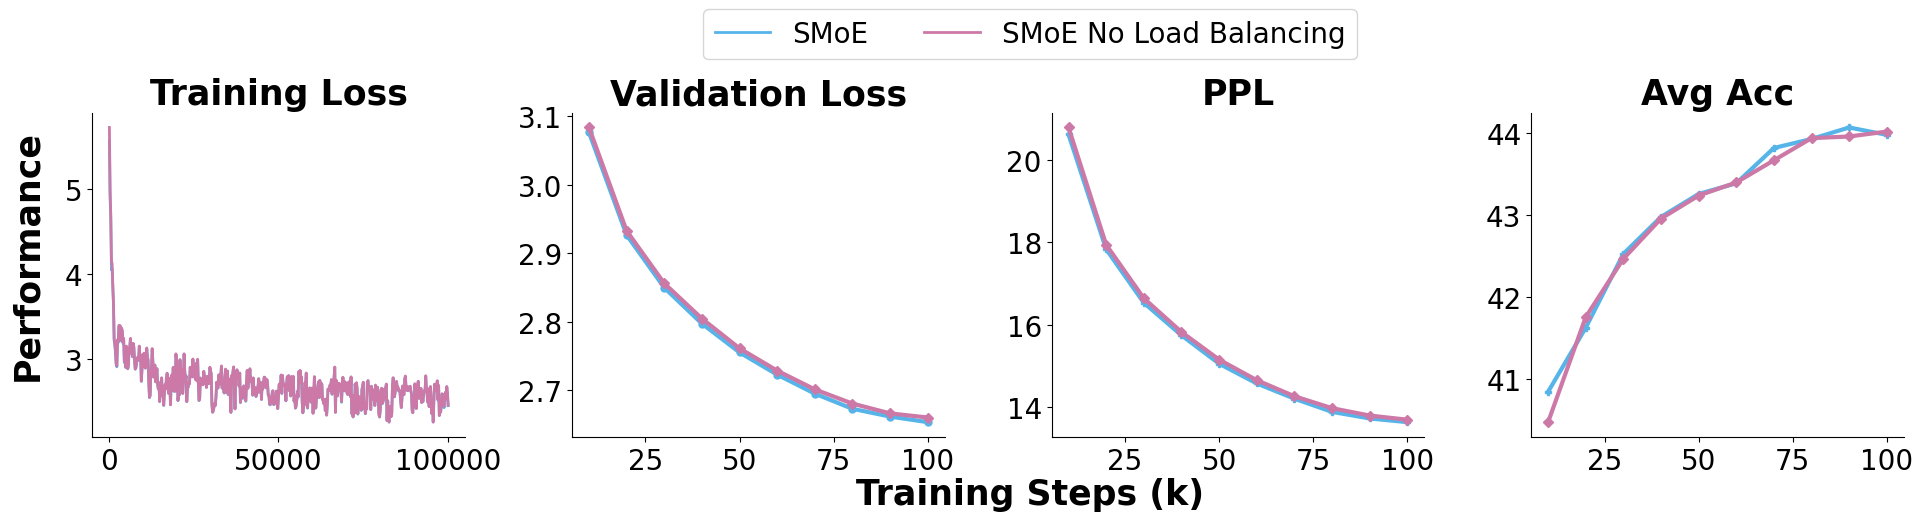

In [4]:
cvd_palette = {
    "smoe": ("#0072B2", "o"), 
    "smoe_shared": ("#D55E00", "s"), 
    "smoe_deepseek": ("#009E73", "^"), 
    "moe_plus_plus": ("#F0E442", "v"),
    "smoe_sigmoid": ("#CC79A7", "D"), 
    "tcmoe": ("#56B4E9", "P"), 
    "xmoe": ("#E69F00", "X"),
}

fig, axs = plt.subplots(1, 4, figsize=(20, 4.8), sharex=False, sharey=False)

# Set shared labels
fig.text(0.55, 0., 'Training Steps (k)', ha='center', fontsize=25, weight='bold')
fig.text(0.04, 0.52, 'Performance', va='center', rotation='vertical', fontsize=25, weight='bold')

# For legend collection
lines = []
labels = []

for i, ax in enumerate(axs):
    if i == 0:
        #  for Training Loss
        l1, = ax.plot(steps_training, log_info_training["Training Loss"]["smoe"], linewidth=2, color=cvd_palette["tcmoe"][0], marker=cvd_palette["smoe"][1], markersize=0)
        l2, = ax.plot(steps_training, log_info_training["Training Loss"]["smoe_nolb"], linewidth=2, color=cvd_palette["smoe_sigmoid"][0], marker=cvd_palette["smoe_sigmoid"][1], markersize=0)
        lines.extend([l1, l2]) 
        labels.extend(["SMoE", "SMoE No Load Balancing"])
        ax.set_title("Training Loss", fontsize=25, weight='bold')
    elif i == 1:
        #  for Validation Loss
        ax.plot(steps_validation, log_info_validation["Validation Loss"]["smoe"], linewidth=3, color=cvd_palette["tcmoe"][0], marker=cvd_palette["smoe"][1], markersize=5)
        ax.plot(steps_validation, log_info_validation["Validation Loss"]["smoe_nolb"], linewidth=3, color=cvd_palette["smoe_sigmoid"][0], marker=cvd_palette["smoe_sigmoid"][1], markersize=5)
        ax.set_title("Validation Loss", fontsize=25, weight='bold')
    elif i == 2:
        # for PPL
        ax.plot(data["Steps"], data["SMoE"]["PPL"], linewidth=3, color=cvd_palette["tcmoe"][0], marker=cvd_palette["tcmoe"][1], markersize=5)
        ax.plot(data["Steps"], data["SMoE_nolb"]["PPL"], linewidth=3, color=cvd_palette["smoe_sigmoid"][0], marker=cvd_palette["smoe_sigmoid"][1], markersize=5)
        ax.set_title("PPL", fontsize=25, weight='bold')
    elif i == 3:
        # for Average
        ax.plot(data["Steps"], data["SMoE"]["Average"], linewidth=3, color=cvd_palette["tcmoe"][0], marker=cvd_palette["tcmoe"][1], markersize=5)
        ax.plot(data["Steps"], data["SMoE_nolb"]["Average"], linewidth=3, color=cvd_palette["smoe_sigmoid"][0], marker=cvd_palette["smoe_sigmoid"][1], markersize=5)
        ax.set_title("Avg Acc", fontsize=25, weight='bold')
    
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

# Create a global legend in the right
fig.legend(lines, labels, loc='upper center', ncol=4, fontsize=20, bbox_to_anchor=(0.55, 1.06))

# plt.tight_layout(rect=[0.06, 0.25, 1, 1.3])  # adjust bottom for legend space
plt.tight_layout(rect=[0.06, 0.03, 1, 0.92])  # leave top 8% blank
plt.savefig('/home/fpt/moeut_training_code/paper/deepseek/libmoe_fig/load_balancing_log.pdf', format='pdf', bbox_inches='tight')
plt.show()

### 679M

In [3]:
event_smoe = EventAccumulator('/home/fpt/moeut_training_code/tensorboard/679m/smoe/tensorboard')
event_smoe.Reload()  # Load the events
event_smoe_nolb = EventAccumulator('/home/fpt/moeut_training_code/tensorboard/679m/smoe_nolb/tensorboard')
event_smoe_nolb.Reload()  # Load the events

In [4]:
# steps_training = list(range(60, 400001, 60))
steps_smoe = [event_smoe.Scalars('train/loss')[i].step for i in range(len(event_smoe.Scalars('train/loss')))]
steps_smoe_nolb = [event_smoe_nolb.Scalars('train/loss')[i].step for i in range(len(event_smoe_nolb.Scalars('train/loss')))]
steps_training = list(set(steps_smoe) & set(steps_smoe_nolb))
steps_training.sort()
steps_training = list(filter(lambda x: x % 200 == 0, steps_training))

steps_validation = list(range(20, 401, 20))
steps = steps_validation

data = {
    "Steps": np.array(steps_validation),
    "SMoE_nolb": {
        "PPL": np.array([
            12.31, 11.76, 11.37, 11.08, 10.85, 10.65, 10.40, 10.27, 10.11, 9.97,
            9.85, 9.74, 9.65, 9.57, 9.49, 9.43, 9.39, 9.35, 9.39, 9.35
        ]),
        "Average": np.array([
            44.48, 45.23, 45.64, 46.23, 46.33, 46.22, 46.72, 47.18, 46.94, 47.64,
            47.34, 47.66, 47.59, 47.91, 48.54, 48.32, 48.18, 48.09, 48.00, 47.94
        ]),
    },
    "SMoE": {
        "PPL": np.array([
            15.20, 13.34, 12.45, 11.87, 11.51, 11.23, 11.00, 10.81, 10.58, 10.42,
            10.27, 10.12, 10.01, 9.90, 9.80, 9.72, 9.64, 9.58, 9.54, 9.51
        ]),
        "Average": np.array([
            41.90, 43.67, 44.22, 44.77, 45.49, 45.94, 45.97, 46.25, 46.71, 46.86,
            46.80, 47.15, 47.33, 47.67, 47.18, 47.43, 48.01, 47.84, 47.89, 47.71
        ]),
    }
}

def filter_duplicate_steps(events, get_steps):
    seen_steps = set()
    filtered = []
    for event in events:
        if event.step not in get_steps:
            continue

        if event.step not in seen_steps:
            filtered.append(event.value)
            seen_steps.add(event.step)
            
    return filtered

log_info_training = {
    "Training Loss": {
        "smoe": filter_duplicate_steps(event_smoe.Scalars('train/loss'), steps_training),
        "smoe_nolb": filter_duplicate_steps(event_smoe_nolb.Scalars('train/loss'), steps_training),
    }
}

log_info_validation = {
    "Validation Loss": {
        "smoe": filter_duplicate_steps(event_smoe.Scalars('validation/val/loss'), list(map(lambda x: x * 1000, steps_validation))),
        "smoe_nolb": filter_duplicate_steps(event_smoe_nolb.Scalars('validation/val/loss'), list(map(lambda x: x * 1000, steps_validation))),
    }
}

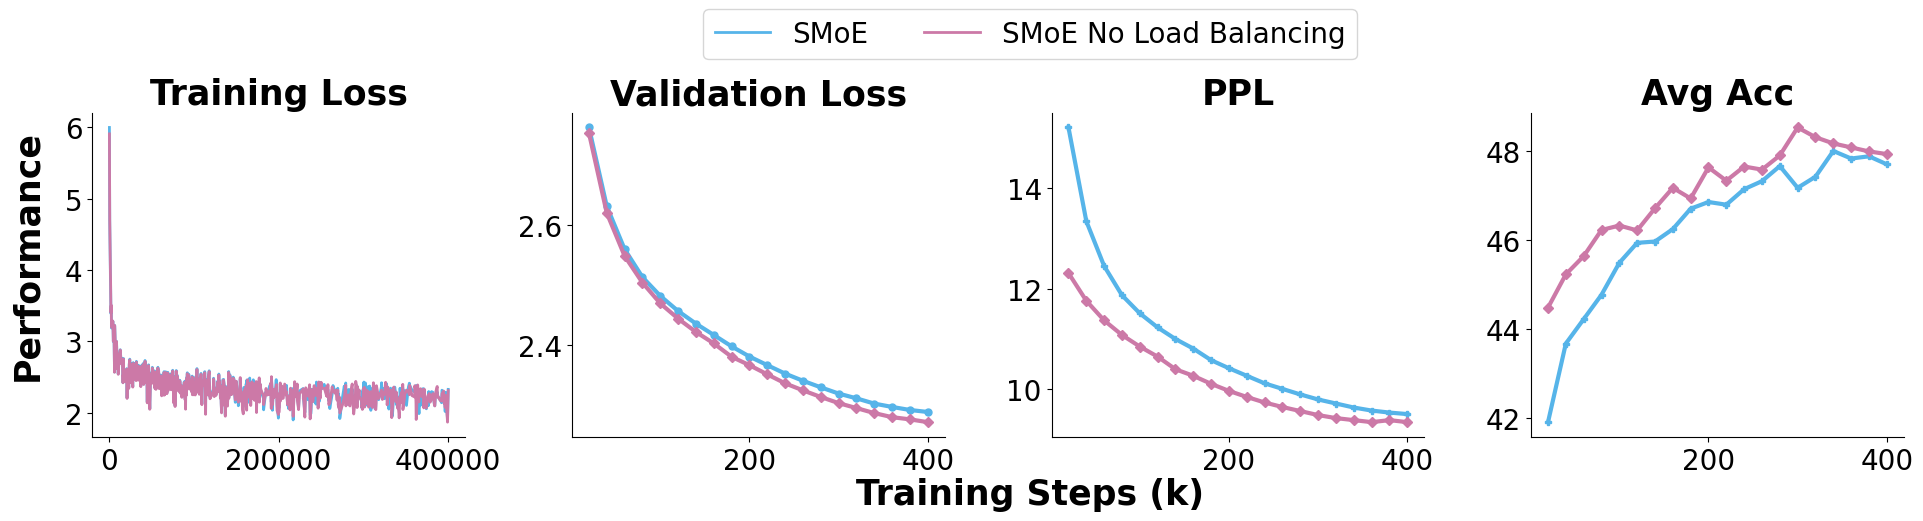

In [5]:
cvd_palette = {
    "smoe": ("#0072B2", "o"), 
    "smoe_shared": ("#D55E00", "s"), 
    "smoe_deepseek": ("#009E73", "^"), 
    "moe_plus_plus": ("#F0E442", "v"),
    "smoe_sigmoid": ("#CC79A7", "D"), 
    "tcmoe": ("#56B4E9", "P"), 
    "xmoe": ("#E69F00", "X"),
}

fig, axs = plt.subplots(1, 4, figsize=(20, 4.8), sharex=False, sharey=False)

# Set shared labels
fig.text(0.55, 0., 'Training Steps (k)', ha='center', fontsize=25, weight='bold')
fig.text(0.04, 0.52, 'Performance', va='center', rotation='vertical', fontsize=25, weight='bold')

# For legend collection
lines = []
labels = []

for i, ax in enumerate(axs):
    if i == 0:
        #  for Training Loss
        l1, = ax.plot(steps_training, log_info_training["Training Loss"]["smoe"], linewidth=2, color=cvd_palette["tcmoe"][0], marker=cvd_palette["smoe"][1], markersize=0)
        l2, = ax.plot(steps_training, log_info_training["Training Loss"]["smoe_nolb"], linewidth=2, color=cvd_palette["smoe_sigmoid"][0], marker=cvd_palette["smoe_sigmoid"][1], markersize=0)
        lines.extend([l1, l2]) 
        labels.extend(["SMoE", "SMoE No Load Balancing"])
        ax.set_title("Training Loss", fontsize=25, weight='bold')
    elif i == 1:
        #  for Validation Loss
        ax.plot(steps_validation, log_info_validation["Validation Loss"]["smoe"], linewidth=3, color=cvd_palette["tcmoe"][0], marker=cvd_palette["smoe"][1], markersize=5)
        ax.plot(steps_validation, log_info_validation["Validation Loss"]["smoe_nolb"], linewidth=3, color=cvd_palette["smoe_sigmoid"][0], marker=cvd_palette["smoe_sigmoid"][1], markersize=5)
        ax.set_title("Validation Loss", fontsize=25, weight='bold')
    elif i == 2:
        # for PPL
        ax.plot(data["Steps"], data["SMoE"]["PPL"], linewidth=3, color=cvd_palette["tcmoe"][0], marker=cvd_palette["tcmoe"][1], markersize=5)
        ax.plot(data["Steps"], data["SMoE_nolb"]["PPL"], linewidth=3, color=cvd_palette["smoe_sigmoid"][0], marker=cvd_palette["smoe_sigmoid"][1], markersize=5)
        ax.set_title("PPL", fontsize=25, weight='bold')
    elif i == 3:
        # for Average
        ax.plot(data["Steps"], data["SMoE"]["Average"], linewidth=3, color=cvd_palette["tcmoe"][0], marker=cvd_palette["tcmoe"][1], markersize=5)
        ax.plot(data["Steps"], data["SMoE_nolb"]["Average"], linewidth=3, color=cvd_palette["smoe_sigmoid"][0], marker=cvd_palette["smoe_sigmoid"][1], markersize=5)
        ax.set_title("Avg Acc", fontsize=25, weight='bold')
    
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

# Create a global legend in the right
fig.legend(lines, labels, loc='upper center', ncol=4, fontsize=20, bbox_to_anchor=(0.55, 1.06))

# plt.tight_layout(rect=[0.06, 0.25, 1, 1.3])  # adjust bottom for legend space
plt.tight_layout(rect=[0.06, 0.03, 1, 0.92])  # leave top 8% blank
plt.savefig('/home/fpt/moeut_training_code/paper/deepseek/libmoe_fig/load_balancing_log_679M.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Dense and Sparse

In [40]:
import json
import numpy as np
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [41]:
event_smoe_679m = EventAccumulator('/home/fpt/moeut_training_code/tensorboard/679m/smoe/tensorboard')
event_smoe_679m.Reload()  # Load the events
event_dense_679m = EventAccumulator('/home/fpt/moeut_training_code/tensorboard/679m/dense/tensorboard')
event_dense_679m.Reload()  # Load the events

event_smoe_158m = EventAccumulator('/home/fpt/moeut_training_code/tensorboard/158m/smoe/tensorboard')
event_smoe_158m.Reload()  # Load the events
event_dense_158m = EventAccumulator('/home/fpt/moeut_training_code/tensorboard/158m/dense/tensorboard')
event_dense_158m.Reload()  # Load the events

In [42]:
# steps_training = list(range(60, 400001, 60))
steps_smoe_679m = [event_smoe_679m.Scalars('train/loss')[i].step for i in range(len(event_smoe_679m.Scalars('train/loss')))]
steps_dense_679m = [event_dense_679m.Scalars('train/loss')[i].step for i in range(len(event_dense_679m.Scalars('train/loss')))]
steps_training_679m = list(set(steps_smoe_679m) & set(steps_dense_679m))
steps_training_679m.sort()
steps_training_679m = list(filter(lambda x: x % 100 == 0, steps_training_679m))

steps_smoe_158m = [event_smoe_158m.Scalars('train/loss')[i].step for i in range(len(event_smoe_158m.Scalars('train/loss')))]
steps_dense_158m = [event_dense_158m.Scalars('train/loss')[i].step for i in range(len(event_dense_158m.Scalars('train/loss')))]
steps_training_158m = list(set(steps_smoe_158m) & set(steps_dense_158m))
steps_training_158m.sort()
steps_training_158m = list(filter(lambda x: x % 100 == 0, steps_training_158m))

steps_validation_679m = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400]
steps_679m = steps_validation_679m
steps_validation_158m = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
steps_158m = steps_validation_158m

data_679m = {
    "Steps": np.array(steps_validation_679m),
    "SMoE": {
        "PPL": np.array([
            17.50, 15.53, 14.60, 14.00, 13.61, 13.34, 13.11, 12.89, 12.65, 12.49,
            12.33, 12.20, 12.06, 11.93, 11.83, 11.74, 11.65, 11.60, 11.56, 11.51
        ]),
        "Average": np.array([
            40.86, 42.03, 42.85, 43.08, 43.69, 44.24, 43.76, 43.90, 44.19, 44.68,
            44.43, 44.70, 44.74, 44.70, 44.82, 44.97, 45.22, 45.32, 45.35, 45.19
        ]),
    },
    "dense": {
        "PPL": np.array([
            15.20, 13.34, 12.45, 11.87, 11.51, 11.23, 11.00, 10.81, 10.58, 10.42,
            10.27, 10.12, 10.01, 9.90, 9.80, 9.72, 9.64, 9.58, 9.54, 9.51
        ]),
        "Average": np.array([
            41.90, 43.67, 44.22, 44.77, 45.49, 45.94, 45.97, 46.25, 46.71, 46.86,
            46.80, 47.15, 47.33, 47.67, 47.18, 47.43, 48.01, 47.84, 47.89, 47.71
        ]),
    }
}

data_158m = {
    "Steps": np.array(steps_validation_158m),
    "SMoE": {
        "PPL": np.array([20.62, 17.83, 16.53, 15.74, 15.05, 14.57, 14.20, 13.88, 13.72, 13.63]),
        "Average": np.array([39.85, 40.56, 41.53, 41.91, 42.16, 42.25, 42.57, 42.74, 42.92, 42.90]),
    },
    "dense": {
        "PPL": np.array([24.60, 21.64, 20.21, 19.29, 18.62, 18.08, 17.67, 17.32, 17.13, 17.04]),
        "Average": np.array([38.53, 39.25, 39.74, 40.08, 40.41, 40.65, 40.85, 41.11, 41.24, 40.97]),
    }
}

def filter_duplicate_steps(events, get_steps):
    seen_steps = set()
    filtered = []
    for event in events:
        if event.step not in get_steps:
            continue

        if event.step not in seen_steps:
            filtered.append(event.value)
            seen_steps.add(event.step)
            
    return filtered

log_info_training_679m = {
    "Training Loss": {
        "smoe": filter_duplicate_steps(event_smoe_679m.Scalars('train/loss'), steps_training_679m),
        "dense": filter_duplicate_steps(event_dense_679m.Scalars('train/loss'), steps_training_679m),
    }
}
log_info_validation_679m = {
    "Validation Loss": {
        "smoe": filter_duplicate_steps(event_smoe_679m.Scalars('validation/val/loss'), list(map(lambda x: x * 1000, steps_validation_679m))),
        "dense": filter_duplicate_steps(event_dense_679m.Scalars('validation/val/loss'), list(map(lambda x: x * 1000, steps_validation_679m))),
    }
}

log_info_training_158m = {
    "Training Loss": {
        "smoe": filter_duplicate_steps(event_smoe_158m.Scalars('train/loss'), steps_training_158m),
        "dense": filter_duplicate_steps(event_dense_158m.Scalars('train/loss'), steps_training_158m),
    }
}
log_info_validation_158m = {
    "Validation Loss": {
        "smoe": filter_duplicate_steps(event_smoe_158m.Scalars('validation/val/loss'), list(map(lambda x: x * 1000, steps_validation_158m))),
        "dense": filter_duplicate_steps(event_dense_158m.Scalars('validation/val/loss'), list(map(lambda x: x * 1000, steps_validation_158m))),
    }
}

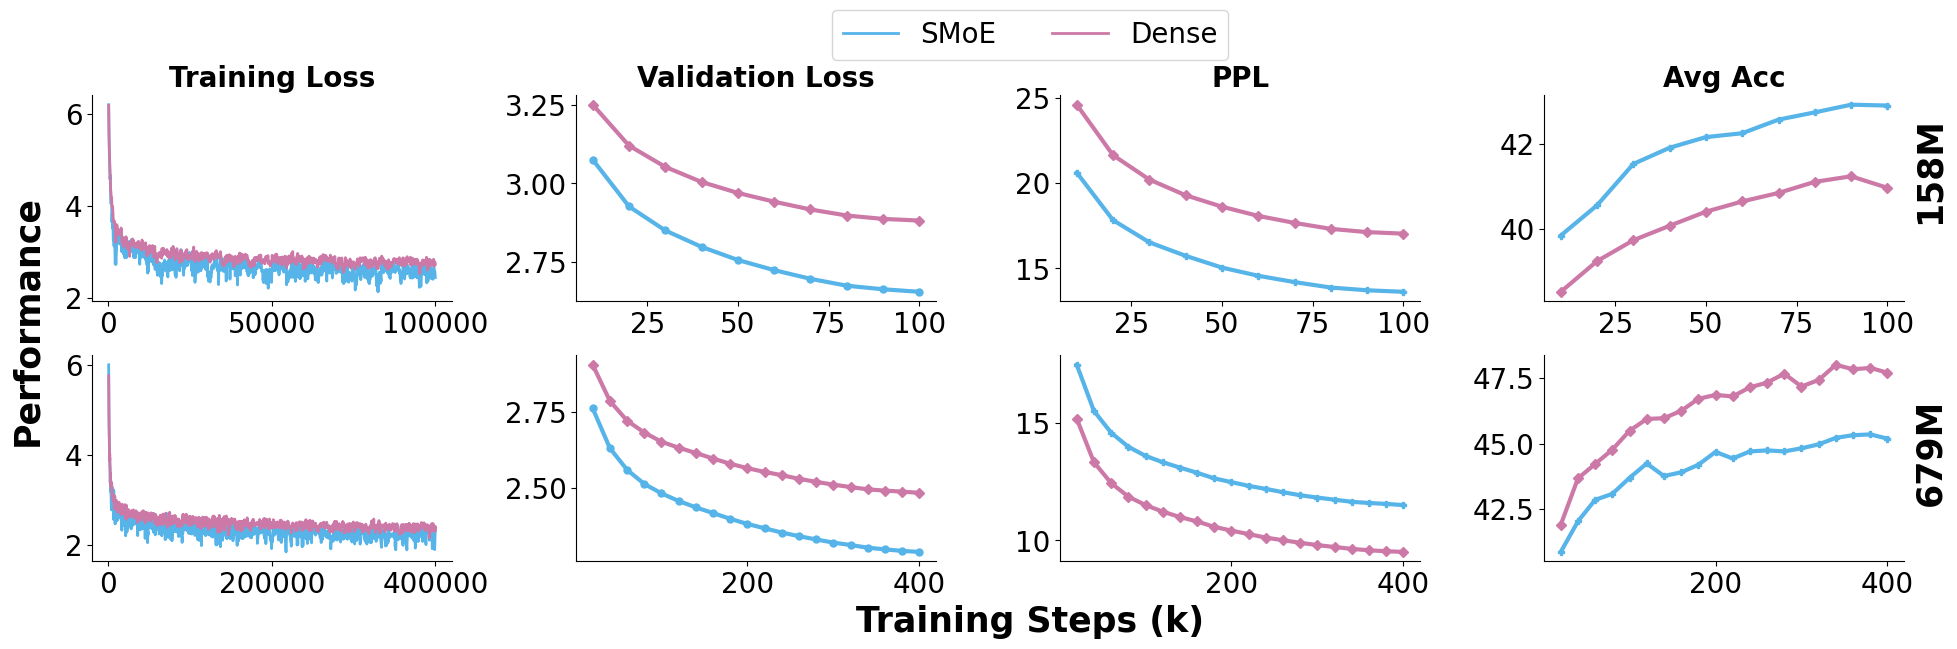

In [46]:
cvd_palette = {
    "smoe": ("#0072B2", "o"), 
    "smoe_shared": ("#D55E00", "s"), 
    "smoe_deepseek": ("#009E73", "^"), 
    "moe_plus_plus": ("#F0E442", "v"),
    "smoe_sigmoid": ("#CC79A7", "D"), 
    "tcmoe": ("#56B4E9", "P"), 
    "xmoe": ("#E69F00", "X"),
}

fig, axs = plt.subplots(2, 4, figsize=(20, 6), sharex=False, sharey=False)

# Set shared labels
fig.text(0.55, 0., 'Training Steps (k)', ha='center', fontsize=25, weight='bold')
fig.text(0.04, 0.52, 'Performance', va='center', rotation='vertical', fontsize=25, weight='bold')

fig.text(1, 0.68, '158M', ha='center', va='bottom', fontsize=25, rotation='vertical', weight='bold')
fig.text(1, 0.21, '679M', ha='center', va='bottom', fontsize=25, rotation='vertical', weight='bold')

# For legend collection
lines = []
labels = []

for i, ax in enumerate(axs):
    if i == 0:
        #  for Training Loss of 158m
        l1, = ax[0].plot(steps_training_158m, log_info_training_158m["Training Loss"]["smoe"], linewidth=2, color=cvd_palette["tcmoe"][0], marker=cvd_palette["smoe"][1], markersize=0)
        l2, = ax[0].plot(steps_training_158m, log_info_training_158m["Training Loss"]["dense"], linewidth=2, color=cvd_palette["smoe_sigmoid"][0], marker=cvd_palette["smoe_sigmoid"][1], markersize=0)
        lines.extend([l1, l2]) 
        labels.extend(["SMoE", "Dense"])
        ax[0].set_title("Training Loss", fontsize=20, weight='bold')
        
        # for validation loss of 158m
        ax[1].plot(steps_validation_158m, log_info_validation_158m["Validation Loss"]["smoe"], linewidth=3, color=cvd_palette["tcmoe"][0], marker=cvd_palette["smoe"][1], markersize=5) 
        ax[1].plot(steps_validation_158m, log_info_validation_158m["Validation Loss"]["dense"], linewidth=3, color=cvd_palette["smoe_sigmoid"][0], marker=cvd_palette["smoe_sigmoid"][1], markersize=5)
        ax[1].set_title("Validation Loss", fontsize=20, weight='bold')
        
        # for PPL of 158m
        ax[2].plot(data_158m["Steps"], data_158m["SMoE"]["PPL"], linewidth=3, color=cvd_palette["tcmoe"][0], marker=cvd_palette["tcmoe"][1], markersize=5)
        ax[2].plot(data_158m["Steps"], data_158m["dense"]["PPL"], linewidth=3, color=cvd_palette["smoe_sigmoid"][0], marker=cvd_palette["smoe_sigmoid"][1], markersize=5)
        ax[2].set_title("PPL", fontsize=20, weight='bold')
        
        # for Average of 158m
        ax[3].plot(data_158m["Steps"], data_158m["SMoE"]["Average"], linewidth=3, color=cvd_palette["tcmoe"][0], marker=cvd_palette["tcmoe"][1], markersize=5)
        ax[3].plot(data_158m["Steps"], data_158m["dense"]["Average"], linewidth=3, color=cvd_palette["smoe_sigmoid"][0], marker=cvd_palette["smoe_sigmoid"][1], markersize=5)
        ax[3].set_title("Avg Acc", fontsize=20, weight='bold')
    elif i == 1:
        # For training loss of 679M
        ax[0].plot(steps_training_679m, log_info_training_679m["Training Loss"]["smoe"], linewidth=2, color=cvd_palette["tcmoe"][0], marker=cvd_palette["smoe"][1], markersize=0)
        ax[0].plot(steps_training_679m, log_info_training_679m["Training Loss"]["dense"], linewidth=2, color=cvd_palette["smoe_sigmoid"][0], marker=cvd_palette["smoe_sigmoid"][1], markersize=0)
        
        # for validation loss of 679m
        ax[1].plot(steps_validation_679m, log_info_validation_679m["Validation Loss"]["smoe"], linewidth=3, color=cvd_palette["tcmoe"][0], marker=cvd_palette["smoe"][1], markersize=5)
        ax[1].plot(steps_validation_679m, log_info_validation_679m["Validation Loss"]["dense"], linewidth=3, color=cvd_palette["smoe_sigmoid"][0], marker=cvd_palette["smoe_sigmoid"][1], markersize=5)
        
        # for PPL of 679m
        ax[2].plot(data_679m["Steps"], data_679m["SMoE"]["PPL"], linewidth=3, color=cvd_palette["tcmoe"][0], marker=cvd_palette["tcmoe"][1], markersize=5)
        ax[2].plot(data_679m["Steps"], data_679m["dense"]["PPL"], linewidth=3, color=cvd_palette["smoe_sigmoid"][0], marker=cvd_palette["smoe_sigmoid"][1], markersize=5)
        
        # for Average of 679m
        ax[3].plot(data_679m["Steps"], data_679m["SMoE"]["Average"], linewidth=3, color=cvd_palette["tcmoe"][0], marker=cvd_palette["tcmoe"][1], markersize=5)
        ax[3].plot(data_679m["Steps"], data_679m["dense"]["Average"], linewidth=3, color=cvd_palette["smoe_sigmoid"][0], marker=cvd_palette["smoe_sigmoid"][1], markersize=5)
        
    for i in range(4):
        ax[i].xaxis.set_tick_params(labelsize=20)
        ax[i].yaxis.set_tick_params(labelsize=20)
        
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)

# Create a global legend in the right
fig.legend(lines, labels, loc='upper center', ncol=4, fontsize=20, bbox_to_anchor=(0.55, 1.06))
# plt.grid(False)

# plt.tight_layout(rect=[0.06, 0.25, 1, 1.3])  # adjust bottom for legend space
plt.tight_layout(rect=[0.06, 0.03, 1, 0.97])  # leave top 8% blank
plt.savefig('/home/fpt/moeut_training_code/paper/deepseek/libmoe_fig/dense_and_sparse.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Expert Co-Activation Overtime

In [70]:
# helper function
def top_k_numpy(logits: np.ndarray, top_k: int, dim: int) -> np.ndarray:
    """Implementation of top_k in pytorch using numpy's partition function.
    Args:
        logits:  shape (L, T, N) — L layers, T tokens, N experts
        top_k:   K, number of experts selected per token
        dim:     dimension to perform top_k on
    Returns:
        top_k_index:  shape (L, T, N) - values at top_k positions different from 0, other is 0
        top_k_logits: shape (L, T, N) - values at top_k positions are the original values, other is 0
    """
    top_k_index = np.zeros_like(logits)
    top_k_index[np.arange(logits.shape[0])[:, None, None], np.arange(logits.shape[1])[None, :, None], np.argpartition(logits, -top_k, axis=dim)[:, :, -top_k:]] = 1
    
    top_k_value = logits * top_k_index

    return top_k_index, top_k_value

def extract_coactivation(logits: np.ndarray, top_k: int = 8) -> np.ndarray:
    n_layers, n_tokens, n_experts = logits.shape
    result = np.zeros((n_layers, n_experts, n_experts))
    
    top_k_index, top_k_value = top_k_numpy(logits, top_k, dim=-1)
    result = np.matmul(top_k_index.transpose(0, 2, 1), top_k_index)
    return result


def extract_coactivation_from_folder(logits_folder: str, top_k: int = 8) -> np.ndarray:
    logits_list_path = glob.glob(os.path.join(logits_folder, "*.npy"))
    logits_list_path.sort(key=lambda x: int(x.split("-")[-1].split(".")[0]))
    
    coactivation_list = []
    for path in logits_list_path:
        logits = np.load(path)
        coactivation = extract_coactivation(logits, top_k)
        coactivation_list.append(coactivation)
    return np.array(coactivation_list)

In [ ]:
def plot_coactivation(coactivation: np.ndarray, top_k_plot: int=15, step: int=0, layer: int=0) -> (np.ndarray, np.ndarray):
    expert_coactivation_layer = coactivation[step][layer]
    expert_coactivation_without_diag = expert_coactivation_layer - np.diag(np.diag(expert_coactivation_layer))
    
    # top_k_index and top_k_value of expert_coactivation_without_diag.sum(0)
    top_k_index = np.argsort(expert_coactivation_without_diag.sum(0))[- top_k_plot:]
    top_k_value = expert_coactivation_without_diag[top_k_index][:, top_k_index]
    
    return top_k_index, top_k_value

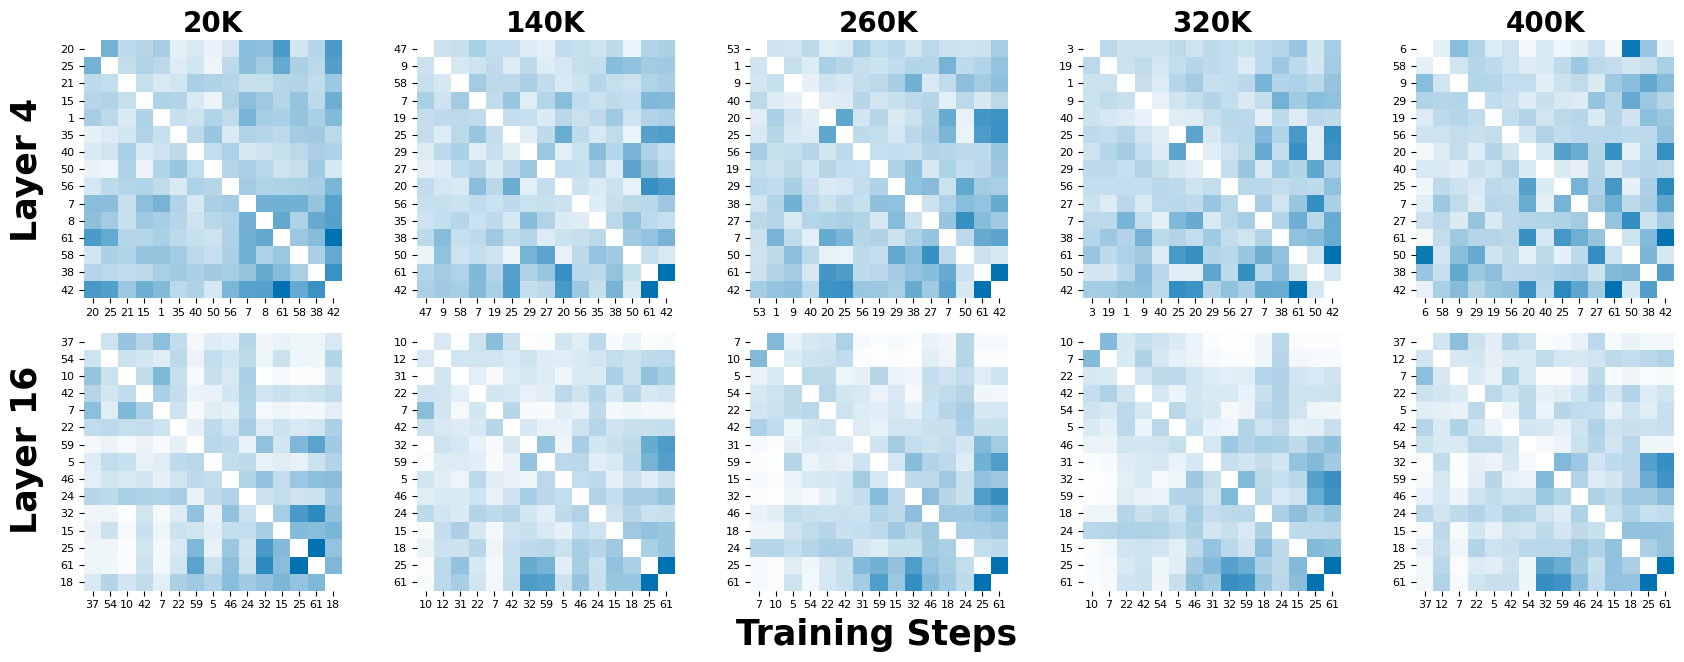

In [86]:
from pdf2image import convert_from_path
from matplotlib.colors import LinearSegmentedColormap

expert_coactivation = extract_coactivation_from_folder("/home/fpt/moeut_training_code/paper/deepseek/logits/679M/smoe")

cmap = LinearSegmentedColormap.from_list("white_to_tartan", ["white", "#0072B2"])

fig, axs = plt.subplots(2, 5, figsize=(20, 6.5), sharex=False, sharey=False)

# Set shared labels
fig.text(0.465, 0., 'Training Steps', ha='center', fontsize=25, weight='bold')
# fig.text(0.04, 0.5, '% of tokens assigned', va='center', rotation='vertical', fontsize=25, weight='bold')

fig.text(0.04, 0.62, 'Layer 4', ha='center', va='bottom', fontsize=25, rotation='vertical', weight='bold')
fig.text(0.04, 0.17, 'Layer 16', ha='center', va='bottom', fontsize=25, rotation='vertical', weight='bold')


xlims = [(0, 66), (0, 66)]
xticks = [np.arange(20, 100, 20)] * 2

# For legend collection
lines = []
labels = []
layer = [4, 16]

for i, ax in enumerate(axs):
    if i == 0:
        for i, step in enumerate([0, 6, 12, 15, 19]):
            top_k_index, top_k_value = plot_coactivation(expert_coactivation, top_k_plot=15, step=step, layer=layer[0])
            ax[i].imshow(top_k_value, cmap=cmap)
            ax[i].set_xticks(range(15), top_k_index)
            ax[i].set_yticks(range(15), top_k_index)
            # decrese fontsize of xticks and yticks
            ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=8)
            ax[i].set_yticklabels(ax[i].get_yticklabels(), fontsize=8)
            
        # set label [0, 6, 14, 19]
        ax[0].set_title("20K", fontsize=20, weight='bold')
        ax[1].set_title("140K", fontsize=20, weight='bold')
        ax[2].set_title("260K", fontsize=20, weight='bold')
        ax[3].set_title("320K", fontsize=20, weight='bold')
        ax[4].set_title("400K", fontsize=20, weight='bold')
    elif i == 1:
        for i, step in enumerate([0, 6, 12, 15, 19]):
            top_k_index, top_k_value = plot_coactivation(expert_coactivation, top_k_plot=15, step=step, layer=layer[1])
            ax[i].imshow(top_k_value, cmap=cmap)
            ax[i].set_xticks(range(15), top_k_index)
            ax[i].set_yticks(range(15), top_k_index)
            # decrese fontsize of xticks and yticks
            ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=8)
            ax[i].set_yticklabels(ax[i].get_yticklabels(), fontsize=8)
    
    for i in range(5):
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['left'].set_visible(False)
        ax[i].spines['bottom'].set_visible(False)

# Create a global legend in the right
# fig.legend(lines, labels, loc='upper center', ncol=4, fontsize=20, bbox_to_anchor=(0.55, 1.06))

# plt.tight_layout(rect=[0.06, 0.25, 1, 1.3])  # adjust bottom for legend space
plt.tight_layout(rect=[0.04, 0.03, 0.89, 1.])  # leave top 8% blank
plt.savefig('/home/fpt/moeut_training_code/paper/deepseek/libmoe_fig/expert_coactivation.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Overall Extraction

In [8]:
def make_top_k(router_info: np.ndarray, k: int):
    
    n_layer, n_token, n_expert = router_info.shape
    
    for layer in range(n_layer):
        for token in range(n_token):
            router_info_layer_token = router_info[layer][token]
            router_info_layer_token_top_k = np.argpartition(router_info_layer_token, -k)[-k:]
            router_info[layer][token][router_info_layer_token_top_k] = 1
            # make other values to 0
            router_info[layer][token][~router_info_layer_token_top_k] = 0
    return router_info 

In [9]:
save_folder = "/home/fpt/moeut_training_code/paper/deepseek/router_saturation_158M/smoe_deepseek"
router_info_list_path = glob.glob(os.path.join(save_folder, "*.npy"))
router_info_final_path = os.path.join(save_folder, "model-100000.npy")

# load all checkpoint information in the router_info_list_path
router_info_dict = {}
for path in router_info_list_path:
    router_info = np.load(path)
    # router_info_dict[path] = make_top_k(router_info, 6)
    router_info_dict[path] = router_info

# load the final checkpoint information
router_final_info = np.load(router_info_final_path)
router_final_choose = (router_final_info > 0).astype(int)

In [10]:
# sort the router_info_dict by the number in key name
router_info_dict = sorted(router_info_dict.items(), key=lambda x: int(x[0].split("-")[-1].split(".")[0]))
router_info_dict = dict(router_info_dict)
router_info_dict.keys()

dict_keys(['/home/fpt/moeut_training_code/paper/deepseek/router_saturation_158M/smoe_deepseek/model-10000.npy', '/home/fpt/moeut_training_code/paper/deepseek/router_saturation_158M/smoe_deepseek/model-20000.npy', '/home/fpt/moeut_training_code/paper/deepseek/router_saturation_158M/smoe_deepseek/model-30000.npy', '/home/fpt/moeut_training_code/paper/deepseek/router_saturation_158M/smoe_deepseek/model-40000.npy', '/home/fpt/moeut_training_code/paper/deepseek/router_saturation_158M/smoe_deepseek/model-50000.npy', '/home/fpt/moeut_training_code/paper/deepseek/router_saturation_158M/smoe_deepseek/model-60000.npy', '/home/fpt/moeut_training_code/paper/deepseek/router_saturation_158M/smoe_deepseek/model-70000.npy', '/home/fpt/moeut_training_code/paper/deepseek/router_saturation_158M/smoe_deepseek/model-80000.npy', '/home/fpt/moeut_training_code/paper/deepseek/router_saturation_158M/smoe_deepseek/model-90000.npy', '/home/fpt/moeut_training_code/paper/deepseek/router_saturation_158M/smoe_deepse

In [11]:
def match_stats(router_choose, router_final_choose):
    n_layer = router_choose.shape[0]
    count_match = {}
    for layer in range(n_layer):
        count_match[layer] = 0
        router_choose_layer = router_choose[layer]
        router_final_choose_layer = router_final_choose[layer]
        
        # compare the choose of router_10k and router_final based only on the 1 value
        for i in range(router_choose_layer.shape[0]):
            for j in range(router_choose_layer[i].shape[0]):
                if router_choose_layer[i][j] == 1 and router_final_choose_layer[i][j] == 1:
                    count_match[layer] += 1
    return count_match

## Router Saturation

In [12]:
model_router_saturation_info = {}

for model_name, model_info in router_info_dict.items():
    router_choose = (model_info > 0).astype(int)
    count_match = match_stats(router_choose, router_final_choose)
    count_match_ratio = {layer: count_match[layer] / router_final_choose[layer].sum() * 100 for layer in count_match}
    model_router_saturation_info[model_name] = count_match_ratio

In [13]:
# convert the model_router_saturation_info to pandas dataframe with column name is the number in the key name
model_router_saturation_info_df = pd.DataFrame(model_router_saturation_info)

# make the column name is the number in the key name
model_router_saturation_info_df.columns = [col.split("-")[-1].split(".")[0] for col in model_router_saturation_info_df.columns]
model_router_saturation_info_df.to_csv("/home/fpt/moeut_training_code/paper/deepseek/router_saturation_679M/figs/model_router_saturation_info-shared.csv", index=False)
model_router_saturation_info_df

,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000
0,71.490122,75.218579,78.055906,80.426650,82.894073,85.182850,87.683901,90.296343,92.467423,100.0
1,65.895334,73.432114,78.163094,81.010929,83.770492,86.307272,88.430013,90.956284,92.934006,100.0
2,68.648592,74.594367,78.627575,81.492224,83.913409,86.195881,88.287095,90.329971,91.517444,100.0
3,69.304330,75.680958,79.928541,82.492644,84.682640,86.975620,88.617066,90.250105,91.700294,100.0
4,69.819252,75.996217,79.384195,82.229929,84.569147,86.895755,88.699033,90.100883,92.034468,100.0
5,68.963850,75.372005,79.138293,81.931484,84.283312,86.391341,88.142077,89.627995,91.252627,100.0
6,68.738966,75.107188,78.890290,82.084910,84.340059,85.617907,87.906683,89.516604,91.315679,100.0
7,65.907945,71.780160,76.319882,79.066835,80.992013,83.148382,84.489281,87.147961,88.654897,100.0
8,64.894914,71.088693,74.066835,75.878520,80.153426,81.504834,84.716267,86.540563,87.725935,100.0
9,59.451450,64.716267,69.451450,69.804540,74.749895,77.061791,79.459857,82.877259,83.699033,100.0


In [14]:
color_list = ["#E85B9C", "#C96FA8", "#B07FB2", "#9C8CBA", "#8C96C0", "#4BC0D8", "#46A4C1", "#428EAF", "#3F7CA0", "#3C6E94", "#3A628B", "#313465", "#393962", "#574F57", "#76644C", "#8F7543", "#A3833C", "#F1B921"]
colors = sns.color_palette(color_list)
colors

[(0.9098039215686274, 0.3568627450980392, 0.611764705882353),
 (0.788235294117647, 0.43529411764705883, 0.6588235294117647),
 (0.6901960784313725, 0.4980392156862745, 0.6980392156862745),
 (0.611764705882353, 0.5490196078431373, 0.7294117647058823),
 (0.5490196078431373, 0.5882352941176471, 0.7529411764705882),
 (0.29411764705882354, 0.7529411764705882, 0.8470588235294118),
 (0.27450980392156865, 0.6431372549019608, 0.7568627450980392),
 (0.25882352941176473, 0.5568627450980392, 0.6862745098039216),
 (0.24705882352941178, 0.48627450980392156, 0.6274509803921569),
 (0.23529411764705882, 0.43137254901960786, 0.5803921568627451),
 (0.22745098039215686, 0.3843137254901961, 0.5450980392156862),
 (0.19215686274509805, 0.20392156862745098, 0.396078431372549),
 (0.2235294117647059, 0.2235294117647059, 0.3843137254901961),
 (0.3411764705882353, 0.30980392156862746, 0.3411764705882353),
 (0.4627450980392157, 0.39215686274509803, 0.2980392156862745),
 (0.5607843137254902, 0.4588235294117647, 0.2627450980392157),
 (0.6392156862745098, 0.5137254901960784, 0.23529411764705882),
 (0.9450980392156862, 0.7254901960784313, 0.12941176470588237)]

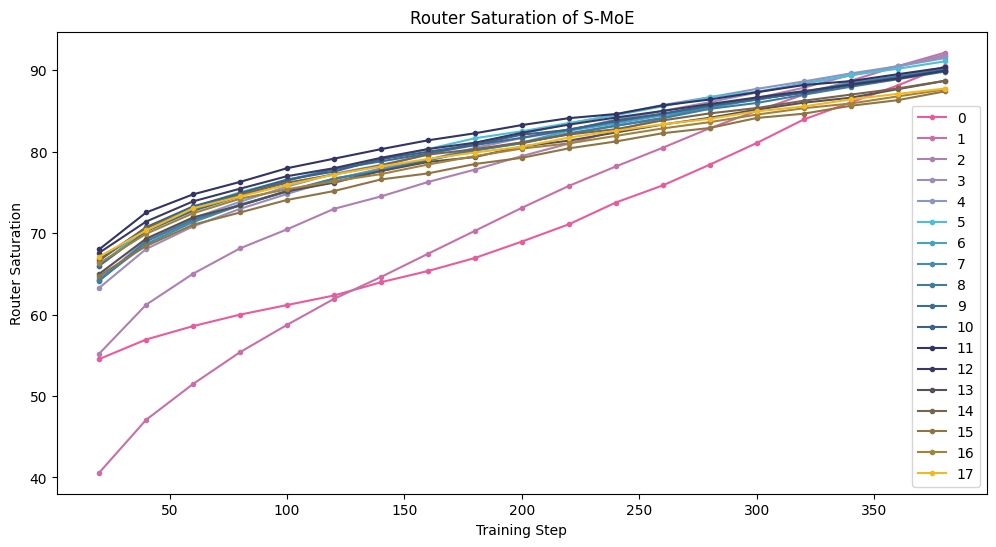

In [15]:
# create a figure to visualize the model_router_saturation_info_df
# the x axis is the training step, which is the column name of the model_router_saturation_info_df, the y axis is the layer_id, which is the row name of the model_router_saturation_info_df

model_router_saturation_info_df = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_saturation_679M/figs/model_router_saturation_info-deepseek.csv")

# colors = sns.color_palette(["#4bc0d8", "#e85b9c", "#f1b921", "#313465"])

# additional colors

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
# print(len(model_router_saturation_info_df.columns[:-1]), len(model_router_saturation_info_df.values.transpose()[:-1]))
# ax.plot(model_router_saturation_info_df.columns[:-1], model_router_saturation_info_df.values.transpose()[:-1], marker="o")

for i in range(18):
    ax.plot(model_router_saturation_info_df.columns[:-1].astype(int) / 1000, model_router_saturation_info_df.values[i][:-1], marker="o", markersize=3, color=colors[i])

# add the legend
ax.legend(model_router_saturation_info_df.index)

ax.set_xlabel("Training Step")
ax.set_ylabel("Router Saturation")
ax.set_title("Router Saturation of S-MoE")

# show the colorbar
# plt.colorbar(colors) 

# plt.grid(True, alpha=0.5, linestyle="--")
# save fig to pdf to /home/fpt/moeut_training_code/paper/deepseek/router_saturation/figs
# plt.savefig("/home/fpt/moeut_training_code/paper/deepseek/router_saturation/figs/router_saturation_smoe_sigmoid.pdf")
plt.show()

In [16]:
color_list = ["#E85B9C", "#C96FA8", "#B07FB2", "#9C8CBA", "#8C96C0", "#4BC0D8", "#46A4C1", "#428EAF", "#3F7CA0", 
              "#3C6E94", "#3A628B", "#313465", "#393962", "#574F57", "#76644C", "#8F7543", "#A3833C", "#F1B921"]
colors = sns.color_palette(color_list)
colors

[(0.9098039215686274, 0.3568627450980392, 0.611764705882353),
 (0.788235294117647, 0.43529411764705883, 0.6588235294117647),
 (0.6901960784313725, 0.4980392156862745, 0.6980392156862745),
 (0.611764705882353, 0.5490196078431373, 0.7294117647058823),
 (0.5490196078431373, 0.5882352941176471, 0.7529411764705882),
 (0.29411764705882354, 0.7529411764705882, 0.8470588235294118),
 (0.27450980392156865, 0.6431372549019608, 0.7568627450980392),
 (0.25882352941176473, 0.5568627450980392, 0.6862745098039216),
 (0.24705882352941178, 0.48627450980392156, 0.6274509803921569),
 (0.23529411764705882, 0.43137254901960786, 0.5803921568627451),
 (0.22745098039215686, 0.3843137254901961, 0.5450980392156862),
 (0.19215686274509805, 0.20392156862745098, 0.396078431372549),
 (0.2235294117647059, 0.2235294117647059, 0.3843137254901961),
 (0.3411764705882353, 0.30980392156862746, 0.3411764705882353),
 (0.4627450980392157, 0.39215686274509803, 0.2980392156862745),
 (0.5607843137254902, 0.4588235294117647, 0.2627450980392157),
 (0.6392156862745098, 0.5137254901960784, 0.23529411764705882),
 (0.9450980392156862, 0.7254901960784313, 0.12941176470588237)]

IndexError: index 9 is out of bounds for axis 0 with size 9

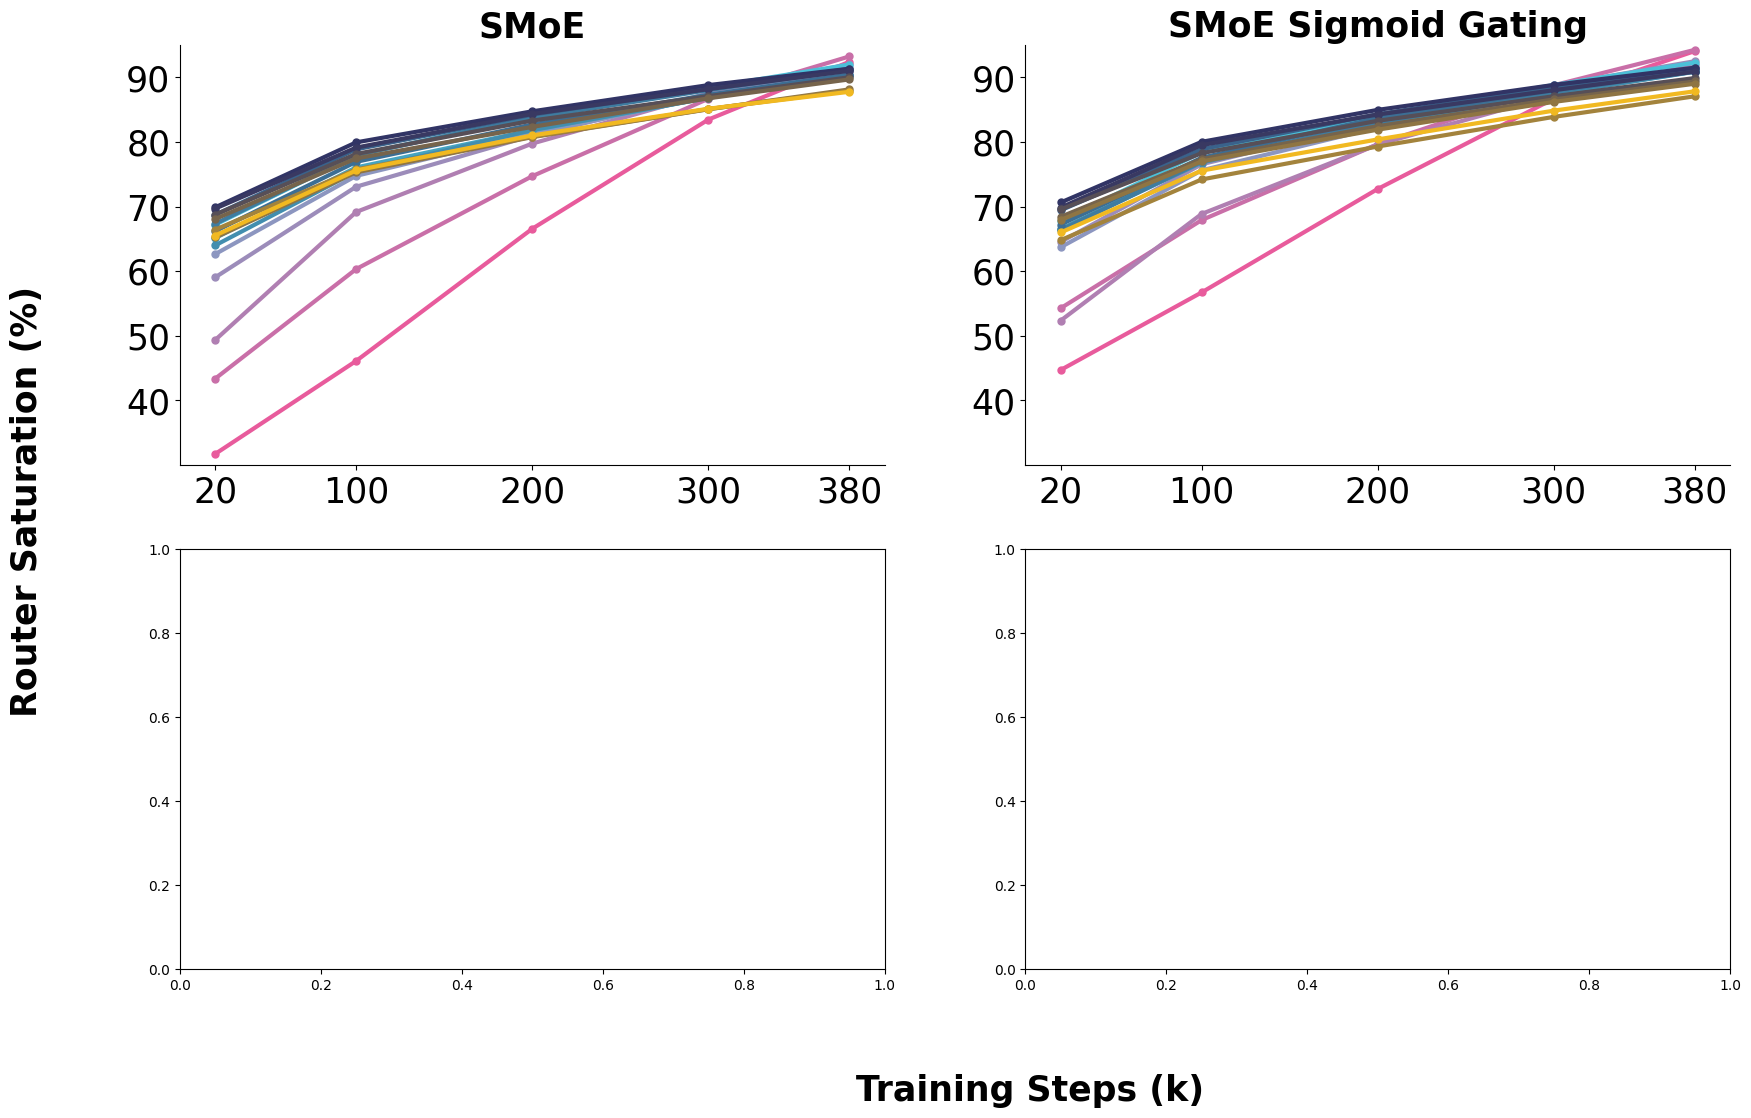

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(20, 12), sharex=False, sharey=False)

smoe_679m = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_saturation_679M/figs/model_router_saturation_info-smoe.csv")
smoe_679m_sigmoid = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_saturation_679M/figs/model_router_saturation_info-smoe-sigmoid.csv")
smoe_679m_shared = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_saturation_679M/figs/model_router_saturation_info-shared.csv")
smoe_679m_deepseek = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_saturation_679M/figs/model_router_saturation_info-deepseek.csv")

# Set shared labels
fig.text(0.55, 0.0, 'Training Steps (k)', ha='center', fontsize=25, weight='bold')
fig.text(0.04, 0.5, 'Router Saturation (%)', va='center', rotation='vertical', fontsize=25, weight='bold')

xlims = [0, 400]
steps_idx_for_plot = [0, 4, 9, 14, 18]
steps_for_plot = [20 + 20 * i for i in steps_idx_for_plot]
xticks = steps_for_plot
yticks = [[40, 50, 60, 70, 80, 90], [40, 50, 60, 70, 80, 90]]
ylims = [[30, 95], [40, 95]]

# For legend collection
lines = []
labels = []

for i, ax in enumerate(axs):
    if i == 0:  # apply for smoe and smoe_sigmoid
        for layer in range(18):
            values_smoe = smoe_679m.values[layer][:-1][steps_idx_for_plot]
            values_smoe_sigmoid = smoe_679m_sigmoid.values[layer][:-1][steps_idx_for_plot]
            
            l1, = ax[0].plot(steps_for_plot, values_smoe, linewidth=3, color=colors[layer], marker="o", markersize=5)
            ax[1].plot(steps_for_plot, values_smoe_sigmoid, linewidth=3, color=colors[layer], marker="o", markersize=5)
            lines.extend([l1])
            labels.extend([f"Layer {layer}"])
            
            ax[0].set_title("SMoE", fontsize=25, weight='bold')
            ax[1].set_title("SMoE Sigmoid Gating", fontsize=25, weight='bold')
            
    elif i == 1:
        for layer in range(18):
            values_shared = smoe_679m_shared.values[layer][:-1][steps_idx_for_plot]
            values_deepseek = smoe_679m_deepseek.values[layer][:-1][steps_idx_for_plot]
            
            ax[0].plot(steps_for_plot, values_shared, linewidth=3, color=colors[layer], marker="o", markersize=5)
            ax[1].plot(steps_for_plot, values_deepseek, linewidth=3, color=colors[layer], marker="o", markersize=5)
            
            ax[0].set_title("DeepSeek-V2", fontsize=25, weight='bold')
            ax[1].set_title("DeepSeek-V3", fontsize=25, weight='bold')

    ax[0].set_xticks(xticks)
    ax[0].set_xlim(xlims)
    ax[1].set_xticks(xticks)
    ax[1].set_xlim(xlims)
    
    ax[0].set_yticks(yticks[i])
    ax[0].set_ylim(ylims[i])
    ax[1].set_yticks(yticks[i])
    ax[1].set_ylim(ylims[i])
    
    ax[0].xaxis.set_tick_params(labelsize=25)
    ax[0].yaxis.set_tick_params(labelsize=25)
    ax[1].xaxis.set_tick_params(labelsize=25)
    ax[1].yaxis.set_tick_params(labelsize=25)
    
    
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    
# Create a global legend in the right
fig.legend(lines, labels, loc='upper center', ncol=6, fontsize=20, bbox_to_anchor=(0.55, 1.05),)

plt.tight_layout(rect=[0.06, 0.02, 1, 0.93])  # leave top 8% blank
plt.savefig('/home/fpt/moeut_training_code/paper/deepseek/results/router_saturation/router_saturation_each_layer_679m.pdf', format='pdf', bbox_inches='tight')
plt.show()


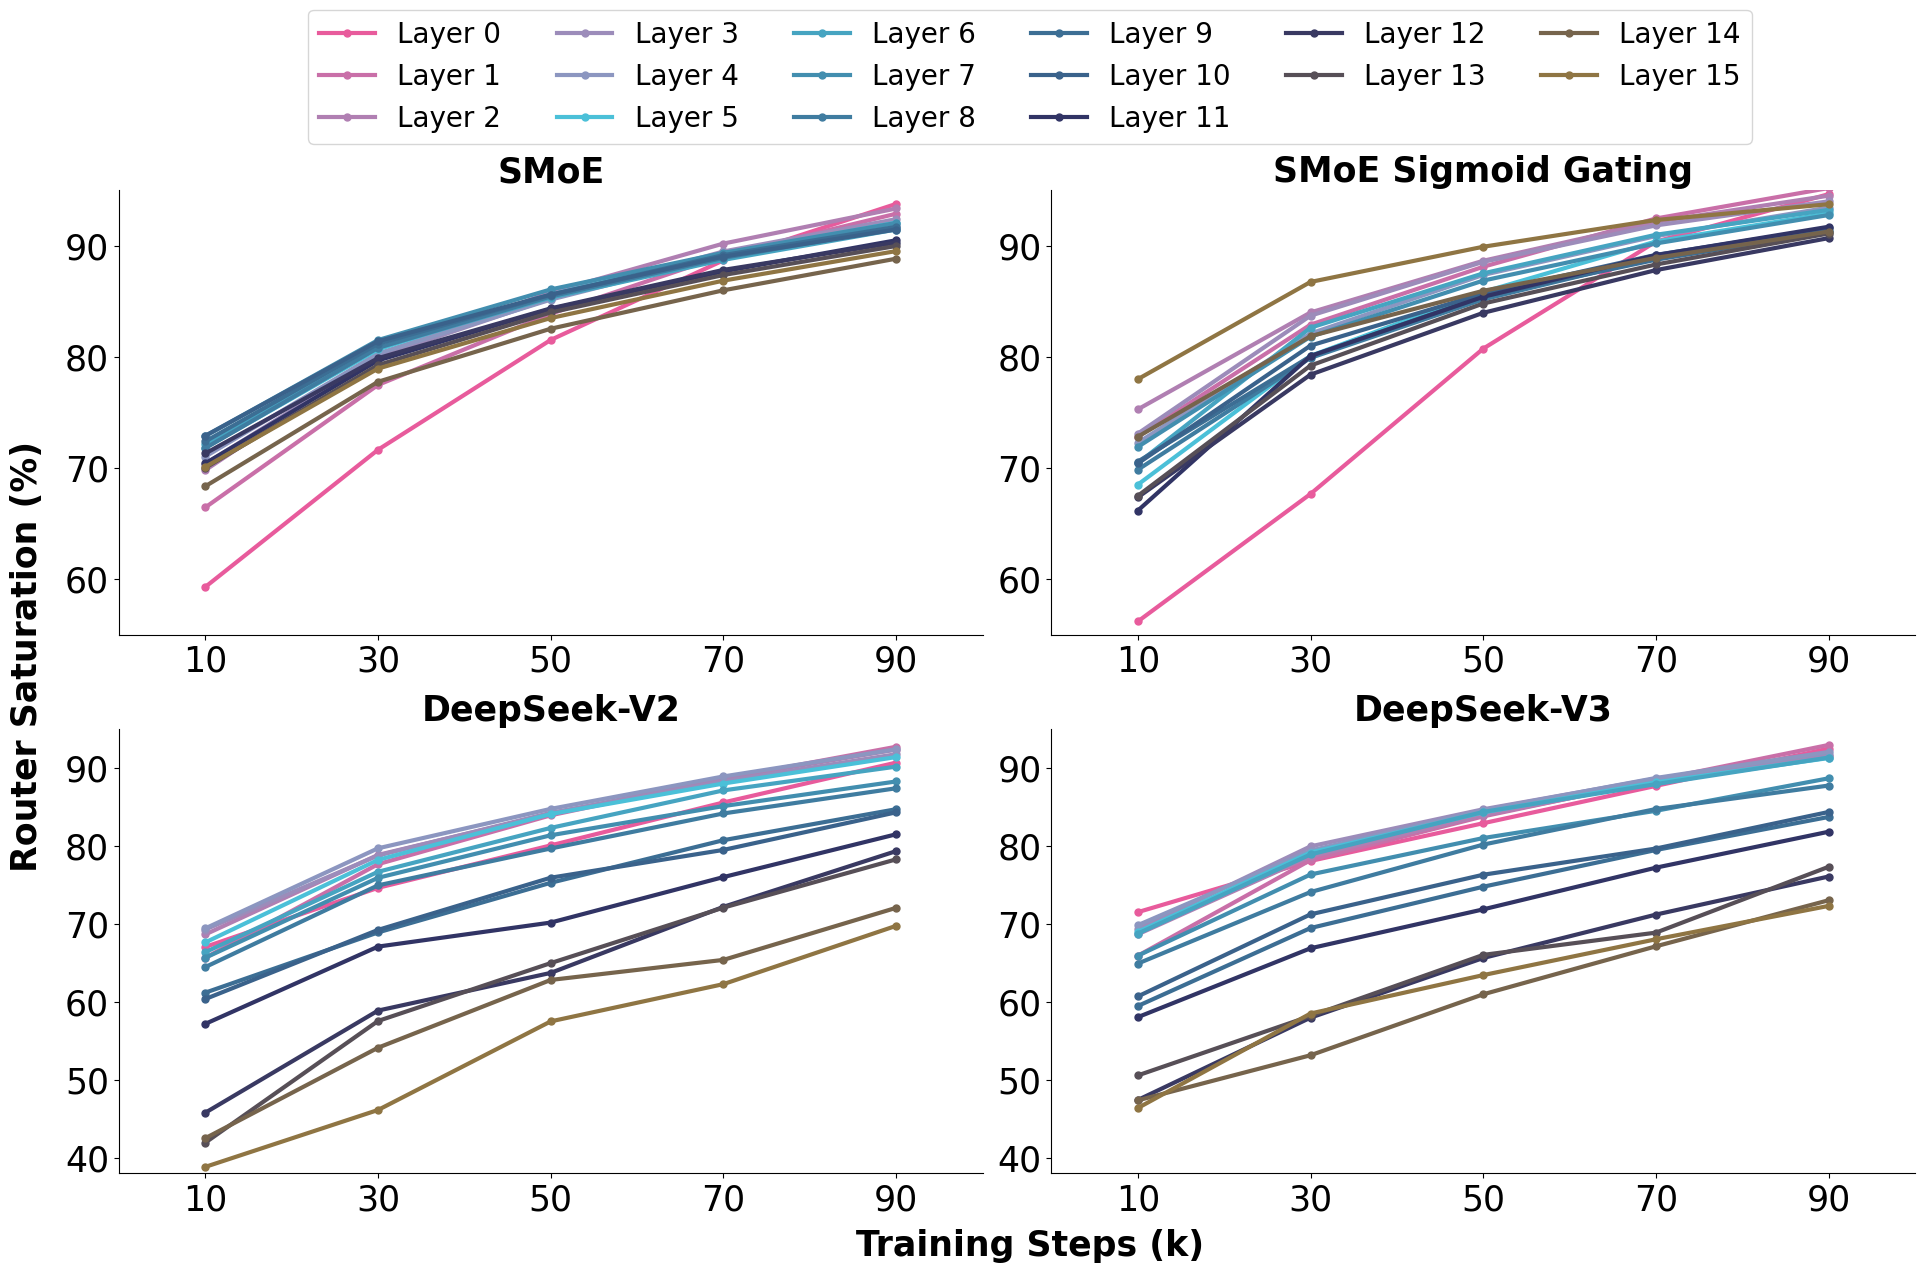

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20, 12), sharex=False, sharey=False)

smoe_158m = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_saturation_158M/figs/model_router_saturation_info-smoe.csv")
smoe_158m_sigmoid = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_saturation_158M/figs/model_router_saturation_info-smoe-sigmoid.csv")
smoe_158m_shared = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_saturation_158M/figs/model_router_saturation_info-shared.csv")
smoe_158m_deepseek = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_saturation_158M/figs/model_router_saturation_info-deepseek.csv")

# Set shared labels
fig.text(0.55, 0.0, 'Training Steps (k)', ha='center', fontsize=25, weight='bold')
fig.text(0.04, 0.5, 'Router Saturation (%)', va='center', rotation='vertical', fontsize=25, weight='bold')

xlims = [0, 100]
steps_idx_for_plot = [0, 2, 4, 6, 8]
steps_for_plot = [10 + 10 * i for i in steps_idx_for_plot]
xticks = steps_for_plot
yticks = [[60, 70, 80, 90], [40, 50, 60, 70, 80, 90]]
ylims = [[55, 95], [38, 95]]

# For legend collection
lines = []
labels = []

for i, ax in enumerate(axs):
    if i == 0:  # apply for smoe and smoe_sigmoid
        for layer in range(16):
            values_smoe = smoe_158m.values[layer][:-1][steps_idx_for_plot]
            values_smoe_sigmoid = smoe_158m_sigmoid.values[layer][:-1][steps_idx_for_plot]
            
            l1, = ax[0].plot(steps_for_plot, values_smoe, linewidth=3, color=colors[layer], marker="o", markersize=5)
            ax[1].plot(steps_for_plot, values_smoe_sigmoid, linewidth=3, color=colors[layer], marker="o", markersize=5)
            lines.extend([l1])
            labels.extend([f"Layer {layer}"])
            
            ax[0].set_title("SMoE", fontsize=25, weight='bold')
            ax[1].set_title("SMoE Sigmoid Gating", fontsize=25, weight='bold')
            
    elif i == 1:
        for layer in range(16):
            values_shared = smoe_158m_shared.values[layer][:-1][steps_idx_for_plot]
            values_deepseek = smoe_158m_deepseek.values[layer][:-1][steps_idx_for_plot]
            
            ax[0].plot(steps_for_plot, values_shared, linewidth=3, color=colors[layer], marker="o", markersize=5)
            ax[1].plot(steps_for_plot, values_deepseek, linewidth=3, color=colors[layer], marker="o", markersize=5)
            
            ax[0].set_title("DeepSeek-V2", fontsize=25, weight='bold')
            ax[1].set_title("DeepSeek-V3", fontsize=25, weight='bold')


    ax[0].set_xticks(xticks)
    ax[0].set_xlim(xlims)
    ax[1].set_xticks(xticks)
    ax[1].set_xlim(xlims)
    
    ax[0].set_yticks(yticks[i])
    ax[0].set_ylim(ylims[i])
    ax[1].set_yticks(yticks[i])
    ax[1].set_ylim(ylims[i])
    
    ax[0].xaxis.set_tick_params(labelsize=25)
    ax[0].yaxis.set_tick_params(labelsize=25)
    ax[1].xaxis.set_tick_params(labelsize=25)
    ax[1].yaxis.set_tick_params(labelsize=25)
    
    
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    
# Create a global legend in the right
fig.legend(lines, labels, loc='upper center', ncol=6, fontsize=20, bbox_to_anchor=(0.55, 1.05),)

plt.tight_layout(rect=[0.06, 0.02, 1, 0.93])  # leave top 8% blank
plt.savefig('/home/fpt/moeut_training_code/paper/deepseek/results/router_saturation/router_saturation_each_layer_158m.pdf', format='pdf', bbox_inches='tight')
plt.show()


## Plot multiple models in the same figure

In [ ]:
ax.plot(router_saturation_smoe_softmax_mean.index[:-1].astype(int) / 1000, router_saturation_smoe_softmax_mean.values[:-1], linewidth=2.5, color='#f1b921')
ax.plot(router_saturation_smoe_sigmoid_mean.index[:-1].astype(int) / 1000, router_saturation_smoe_sigmoid_mean.values[:-1], linewidth=2.5, color='#e85b9c')

ax.plot(router_saturation_smoe_softmax_mean.index[:-1].astype(int) / 1000, router_saturation_smoe_softmax_mean.values[:-1], linewidth=3, color='#4bc0d8')
ax.plot(router_saturation_smoe_sigmoid_mean.index[:-1].astype(int) / 1000, router_saturation_smoe_sigmoid_mean.values[:-1], linewidth=3, color='#313465')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

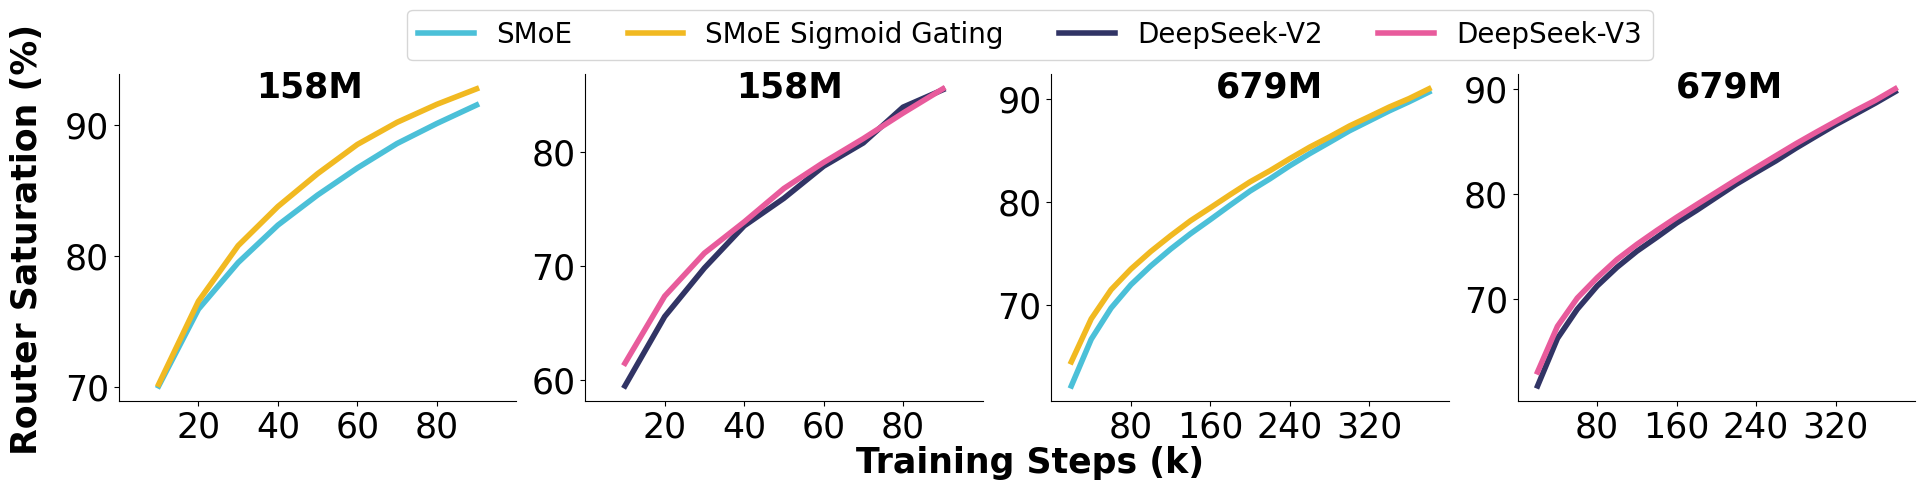

In [ ]:
colors = {
    "smoe": "#4bc0d8",
    "deepseek": "#e85b9c",
    "smoe_norm": "#f1b921",
    "deepseek_shared": "#313465",
}

smoe_158m = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_saturation_158M/figs/model_router_saturation_info-smoe.csv").mean()
smoe_sigmoid_158m = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_saturation_158M/figs/model_router_saturation_info-smoe-sigmoid.csv").mean()

smoe_shared_158m = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_saturation_158M/figs/model_router_saturation_info-shared.csv").mean()
smoe_deepseek_158m = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_saturation_158M/figs/model_router_saturation_info-deepseek.csv").mean()

smoe_679m = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_saturation_679M/figs/model_router_saturation_info-smoe.csv").mean()
smoe_sigmoid_679m = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_saturation_679M/figs/model_router_saturation_info-smoe-sigmoid.csv").mean()

smoe_shared_679m = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_saturation_679M/figs/model_router_saturation_info-shared.csv").mean()
smoe_deepseek_679m = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_saturation_679M/figs/model_router_saturation_info-deepseek.csv").mean()

fig, axs = plt.subplots(1, 4, figsize=(20, 4.5), sharex=False, sharey=False)

# Set shared labels
fig.text(0.55, 0., 'Training Steps (k)', ha='center', fontsize=25, weight='bold')
fig.text(0.04, 0.52, 'Router Saturation (%)', va='center', rotation='vertical', fontsize=25, weight='bold')

fig.text(0.19, 0.82, '158M', ha='center', va='bottom', fontsize=25, weight='bold')
fig.text(0.43, 0.82, '158M', ha='center', va='bottom', fontsize=25, weight='bold')

fig.text(0.67, 0.82, '679M', ha='center', va='bottom', fontsize=25, weight='bold')
fig.text(0.9, 0.82, '679M', ha='center', va='bottom', fontsize=25, weight='bold')


xlims = [(0, 100), (0, 100), (0, 400), (0, 400)]
xticks = [np.arange(20, 100, 20)] * 2 + [np.arange(80, 400, 80)] * 2

# For legend collection
lines = []
labels = []

for i, ax in enumerate(axs):
    if i == 0:
        l1, = ax.plot(smoe_158m.index[:-1].astype(int) / 1000, smoe_158m.values[:-1], linewidth=4, color='#4bc0d8')
        l2, = ax.plot(smoe_sigmoid_158m.index[:-1].astype(int) / 1000, smoe_sigmoid_158m.values[:-1], linewidth=4, color='#f1b921')
        lines.extend([l1, l2]) 
        labels.extend(["SMoE", "SMoE Sigmoid Gating"])
        # ax.set_title("158M", fontsize=25, weight='bold')
    elif i == 1:
        l3, = ax.plot(smoe_shared_158m.index[:-1].astype(int) / 1000, smoe_shared_158m.values[:-1], linewidth=4, color='#313465')
        l4, = ax.plot(smoe_deepseek_158m.index[:-1].astype(int) / 1000, smoe_deepseek_158m.values[:-1], linewidth=4, color='#e85b9c')
        lines.extend([l3, l4])
        labels.extend(["DeepSeek-V2", "DeepSeek-V3"])
        # ax.set_title("158M", fontsize=25, weight='bold')
    elif i == 2:
        ax.plot(smoe_679m.index[:-1].astype(int) / 1000, smoe_679m.values[:-1], linewidth=4, color='#4bc0d8')
        ax.plot(smoe_sigmoid_679m.index[:-1].astype(int) / 1000, smoe_sigmoid_679m.values[:-1], linewidth=4, color='#f1b921')
        # ax.set_title("679M", fontsize=25, weight='bold')
    elif i == 3:
        ax.plot(smoe_shared_679m.index[:-1].astype(int) / 1000, smoe_shared_679m.values[:-1], linewidth=4, color='#313465')
        ax.plot(smoe_deepseek_679m.index[:-1].astype(int) / 1000, smoe_deepseek_679m.values[:-1], linewidth=4, color='#e85b9c')
        # ax.set_title("679M", fontsize=25, weight='bold')

    ax.set_xticks(xticks[i])
    ax.set_xlim(xlims[i])
    
    ax.xaxis.set_tick_params(labelsize=25)
    ax.yaxis.set_tick_params(labelsize=25)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

# Create a global legend in the right
fig.legend(lines, labels, loc='upper center', ncol=4, fontsize=20, bbox_to_anchor=(0.55, 1.06))

# plt.tight_layout(rect=[0.06, 0.25, 1, 1.3])  # adjust bottom for legend space
plt.tight_layout(rect=[0.06, 0.03, 1, 0.92])  # leave top 8% blank
plt.savefig('/home/fpt/moeut_training_code/paper/deepseek/results/router_saturation/router_saturation.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Router Change Rate


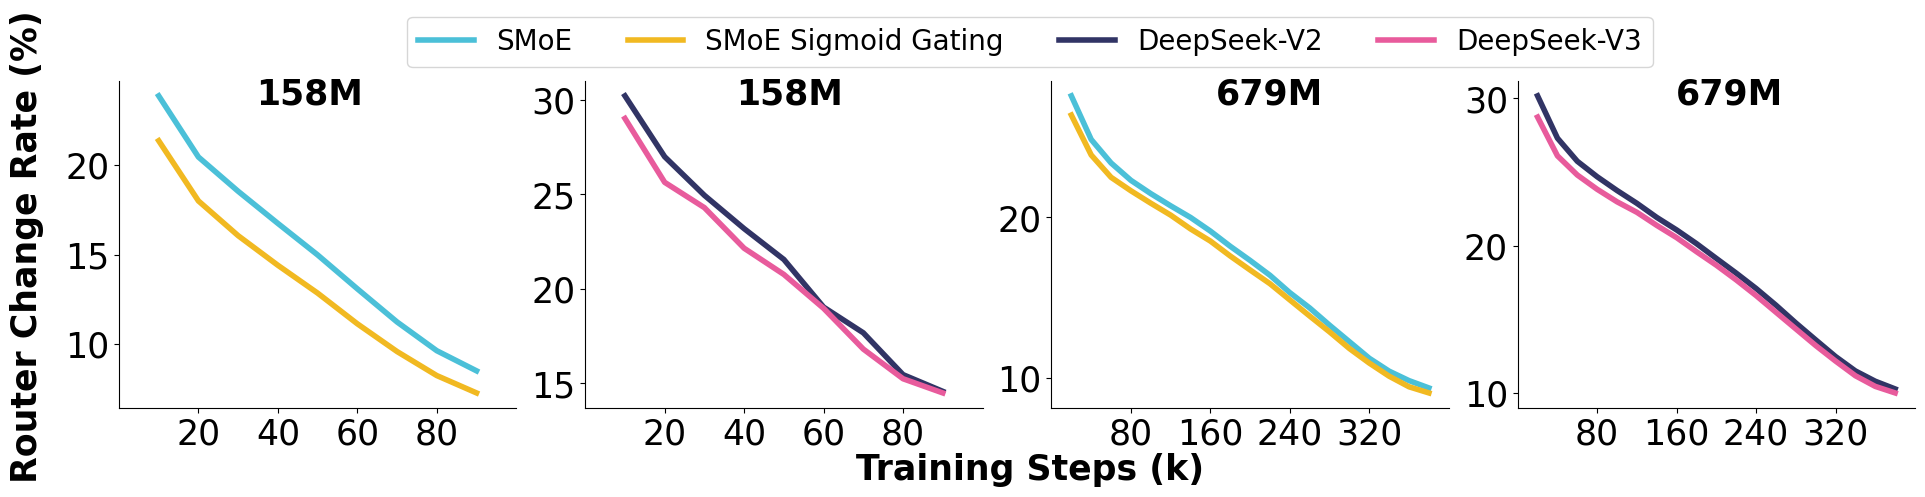

In [ ]:
smoe_158m = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_stability/158M/router_stability_smoe.csv").mean()
smoe_sigmoid_158m = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_stability/158M/router_stability_sigmoid.csv").mean()

smoe_shared_158m = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_stability/158M/router_stability_shared.csv").mean()
smoe_deepseek_158m = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_stability/158M/router_stability_deepseek.csv").mean()

smoe_679m = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_stability/679M/router_stability_smoe.csv").mean()
smoe_sigmoid_679m = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_stability/679M/router_stability_sigmoid.csv").mean()

smoe_shared_679m = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_stability/679M/router_stability_shared.csv").mean()
smoe_deepseek_679m = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_stability/679M/router_stability_deepseek.csv").mean()

fig, axs = plt.subplots(1, 4, figsize=(20, 4.5), sharex=False, sharey=False)

# Set shared labels
# fig.text(0.5, 0.2, 'Training Steps (k)', ha='center', fontsize=25, weight='bold')
# fig.text(0.04, 0.68, 'Router Change Rate (%)', va='center', rotation='vertical', fontsize=25, weight='bold')

# Set shared labels
fig.text(0.55, 0., 'Training Steps (k)', ha='center', fontsize=25, weight='bold')
fig.text(0.04, 0.52, 'Router Change Rate (%)', va='center', rotation='vertical', fontsize=25, weight='bold')

fig.text(0.19, 0.82, '158M', ha='center', va='bottom', fontsize=25, weight='bold')
fig.text(0.43, 0.82, '158M', ha='center', va='bottom', fontsize=25, weight='bold')

fig.text(0.67, 0.82, '679M', ha='center', va='bottom', fontsize=25, weight='bold')
fig.text(0.9, 0.82, '679M', ha='center', va='bottom', fontsize=25, weight='bold')


xlims = [(0, 100), (0, 100), (0, 400), (0, 400)]
xticks = [np.arange(20, 100, 20)] * 2 + [np.arange(80, 400, 80)] * 2

# For legend collection
lines = []
labels = []

for i, ax in enumerate(axs):
    if i == 0:
        l1, = ax.plot(smoe_158m.index.astype(int) / 1000, smoe_158m.values, linewidth=4, color='#4bc0d8')
        l2, = ax.plot(smoe_sigmoid_158m.index.astype(int) / 1000, smoe_sigmoid_158m.values, linewidth=4, color='#f1b921')
        lines.extend([l1, l2])
        labels.extend(["SMoE", "SMoE Sigmoid Gating"])
        # ax.set_title("158M", fontsize=25, weight='bold')
    elif i == 1:
        l3, = ax.plot(smoe_shared_158m.index.astype(int) / 1000, smoe_shared_158m.values, linewidth=4, color='#313465')
        l4, = ax.plot(smoe_deepseek_158m.index.astype(int) / 1000, smoe_deepseek_158m.values, linewidth=4, color='#e85b9c')
        lines.extend([l3, l4])
        labels.extend(["DeepSeek-V2", "DeepSeek-V3"])
        # ax.set_title("158M", fontsize=25, weight='bold')
    elif i == 2:
        ax.plot(smoe_679m.index.astype(int) / 1000, smoe_679m.values, linewidth=4, color='#4bc0d8')
        ax.plot(smoe_sigmoid_679m.index.astype(int) / 1000, smoe_sigmoid_679m.values, linewidth=4, color='#f1b921')
        # ax.set_title("679M", fontsize=25, weight='bold')
    elif i == 3:
        ax.plot(smoe_shared_679m.index.astype(int) / 1000, smoe_shared_679m.values, linewidth=4, color='#313465')
        ax.plot(smoe_deepseek_679m.index.astype(int) / 1000, smoe_deepseek_679m.values, linewidth=4, color='#e85b9c')
        # ax.set_title("679M", fontsize=25, weight='bold')

    ax.set_xticks(xticks[i])
    ax.set_xlim(xlims[i])
    
    ax.xaxis.set_tick_params(labelsize=25)
    ax.yaxis.set_tick_params(labelsize=25)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


# Create a global legend in the right
fig.legend(lines, labels, loc='upper center', ncol=4, fontsize=20, bbox_to_anchor=(0.55, 1.06))

# plt.tight_layout(rect=[0.06, 0.25, 1, 1.3])  # adjust bottom for legend space
plt.tight_layout(rect=[0.06, 0.03, 1, 0.92])  # leave top 8% blank
plt.savefig('/home/fpt/moeut_training_code/paper/deepseek/results/router_change_rate/router_change_rate.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
color_list = ["#E85B9C", "#C96FA8", "#B07FB2", "#9C8CBA", "#8C96C0", "#4BC0D8", "#46A4C1", "#428EAF", "#3F7CA0", 
              "#3C6E94", "#3A628B", "#313465", "#393962", "#574F57", "#76644C", "#8F7543", "#A3833C", "#F1B921"]
colors = sns.color_palette(color_list)
colors

[(0.9098039215686274, 0.3568627450980392, 0.611764705882353),
 (0.788235294117647, 0.43529411764705883, 0.6588235294117647),
 (0.6901960784313725, 0.4980392156862745, 0.6980392156862745),
 (0.611764705882353, 0.5490196078431373, 0.7294117647058823),
 (0.5490196078431373, 0.5882352941176471, 0.7529411764705882),
 (0.29411764705882354, 0.7529411764705882, 0.8470588235294118),
 (0.27450980392156865, 0.6431372549019608, 0.7568627450980392),
 (0.25882352941176473, 0.5568627450980392, 0.6862745098039216),
 (0.24705882352941178, 0.48627450980392156, 0.6274509803921569),
 (0.23529411764705882, 0.43137254901960786, 0.5803921568627451),
 (0.22745098039215686, 0.3843137254901961, 0.5450980392156862),
 (0.19215686274509805, 0.20392156862745098, 0.396078431372549),
 (0.2235294117647059, 0.2235294117647059, 0.3843137254901961),
 (0.3411764705882353, 0.30980392156862746, 0.3411764705882353),
 (0.4627450980392157, 0.39215686274509803, 0.2980392156862745),
 (0.5607843137254902, 0.4588235294117647, 0.2627450980392157),
 (0.6392156862745098, 0.5137254901960784, 0.23529411764705882),
 (0.9450980392156862, 0.7254901960784313, 0.12941176470588237)]

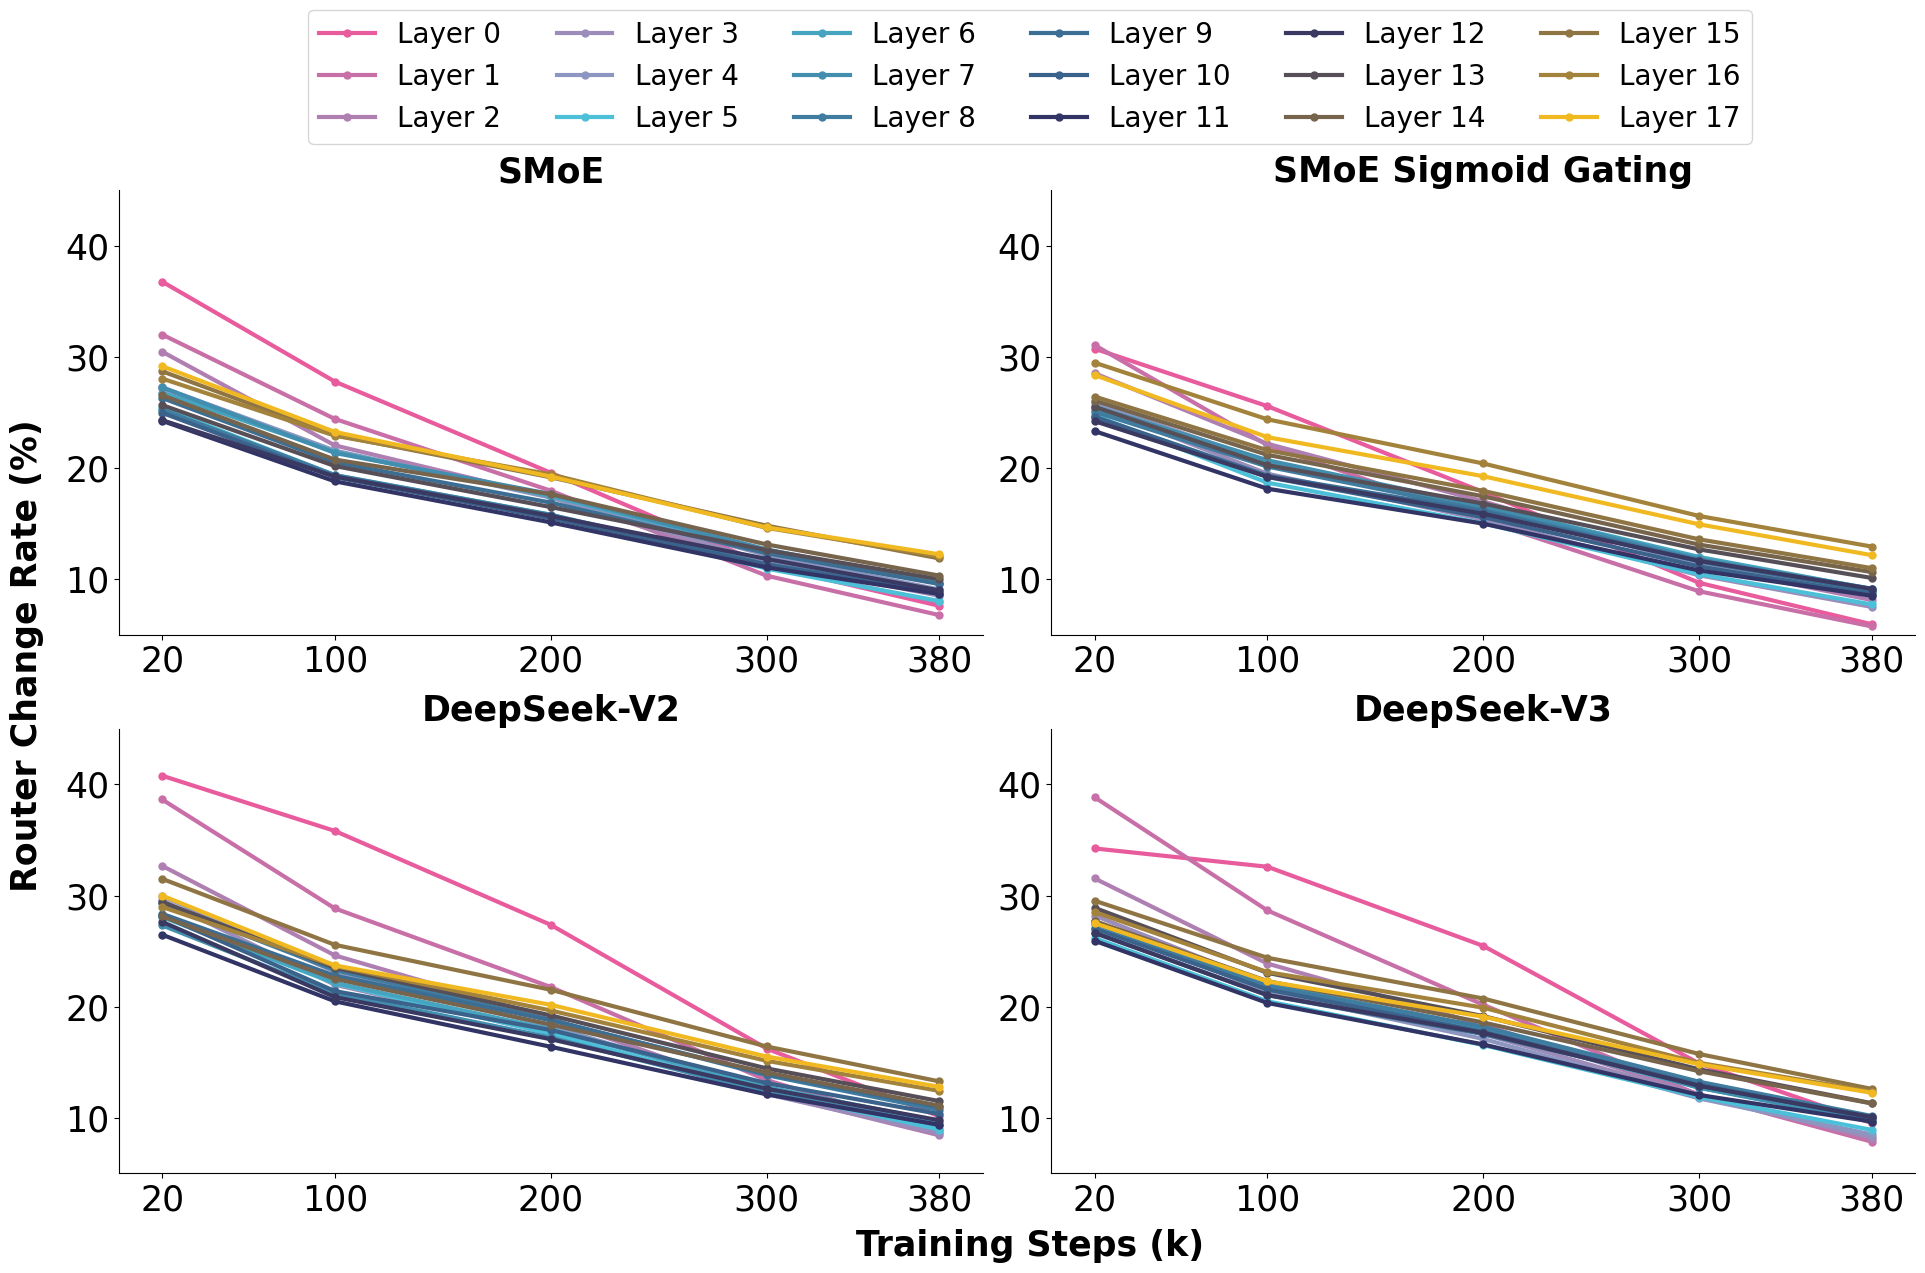

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20, 12), sharex=False, sharey=False)

smoe_679m = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_stability/679M/router_stability_smoe.csv")
smoe_679m_sigmoid = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_stability/679M/router_stability_sigmoid.csv")
smoe_679m_shared = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_stability/679M/router_stability_shared.csv")
smoe_679m_deepseek = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_stability/679M/router_stability_deepseek.csv")

# Set shared labels
fig.text(0.55, 0.0, 'Training Steps (k)', ha='center', fontsize=25, weight='bold')
fig.text(0.04, 0.5, 'Router Change Rate (%)', va='center', rotation='vertical', fontsize=25, weight='bold')

xlims = [0, 400]
steps_idx_for_plot = [0, 4, 9, 14, 18]
steps_for_plot = [20 + 20 * i for i in steps_idx_for_plot]
xticks = steps_for_plot
yticks = [[10, 20, 30, 40], [10, 20, 30, 40]]
ylims = [[5, 45], [5, 45]]

# For legend collection
lines = []
labels = []

for i, ax in enumerate(axs):
    if i == 0:  # apply for smoe and smoe_sigmoid
        for layer in range(18):
            values_smoe = smoe_679m.values[layer][steps_idx_for_plot]
            values_smoe_sigmoid = smoe_679m_sigmoid.values[layer][steps_idx_for_plot]
            
            l1, = ax[0].plot(steps_for_plot, values_smoe, linewidth=3, color=colors[layer], marker="o", markersize=5)
            ax[1].plot(steps_for_plot, values_smoe_sigmoid, linewidth=3, color=colors[layer], marker="o", markersize=5)
            lines.extend([l1])
            labels.extend([f"Layer {layer}"])
            
            ax[0].set_title("SMoE", fontsize=25, weight='bold')
            ax[1].set_title("SMoE Sigmoid Gating", fontsize=25, weight='bold')
            
    elif i == 1:
        for layer in range(18):
            values_shared = smoe_679m_shared.values[layer][steps_idx_for_plot]
            values_deepseek = smoe_679m_deepseek.values[layer][steps_idx_for_plot]
            
            ax[0].plot(steps_for_plot, values_shared, linewidth=3, color=colors[layer], marker="o", markersize=5)
            ax[1].plot(steps_for_plot, values_deepseek, linewidth=3, color=colors[layer], marker="o", markersize=5)
            
            ax[0].set_title("DeepSeek-V2", fontsize=25, weight='bold')
            ax[1].set_title("DeepSeek-V3", fontsize=25, weight='bold')

    ax[0].set_xticks(xticks)
    ax[0].set_xlim(xlims)
    ax[1].set_xticks(xticks)
    ax[1].set_xlim(xlims)
    
    ax[0].set_yticks(yticks[i])
    ax[0].set_ylim(ylims[i])
    ax[1].set_yticks(yticks[i])
    ax[1].set_ylim(ylims[i])
    
    ax[0].xaxis.set_tick_params(labelsize=25)
    ax[0].yaxis.set_tick_params(labelsize=25)
    ax[1].xaxis.set_tick_params(labelsize=25)
    ax[1].yaxis.set_tick_params(labelsize=25)
    
    
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    
# Create a global legend in the right
fig.legend(lines, labels, loc='upper center', ncol=6, fontsize=20, bbox_to_anchor=(0.55, 1.05),)

plt.tight_layout(rect=[0.06, 0.02, 1, 0.93])  # leave top 8% blank
plt.savefig('/home/fpt/moeut_training_code/paper/deepseek/results/router_change_rate/router_change_rate_each_layer_679m.pdf', format='pdf', bbox_inches='tight')
plt.show()


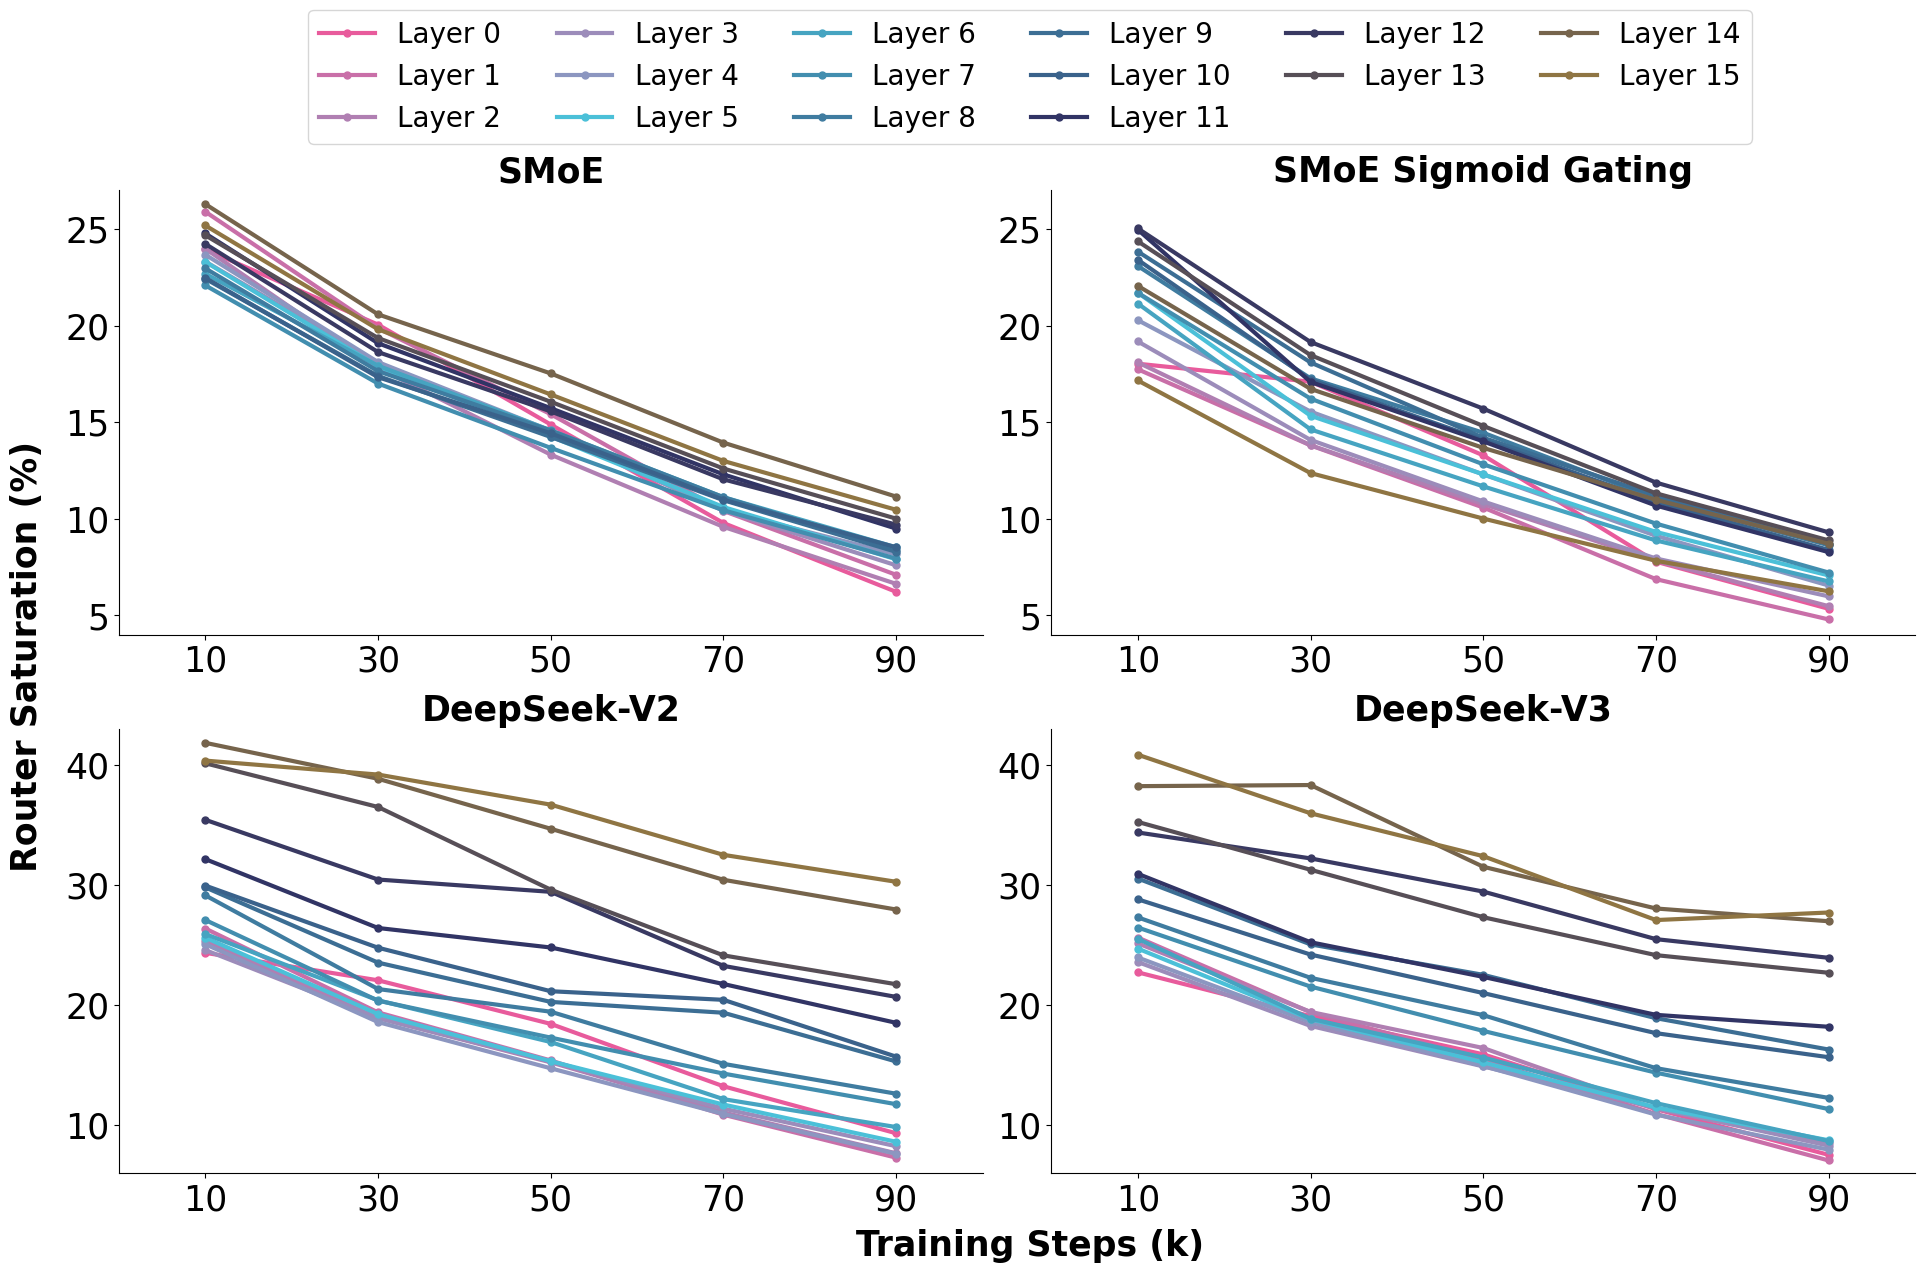

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20, 12), sharex=False, sharey=False)

smoe_158m = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_stability/158M/router_stability_smoe.csv")
smoe_158m_sigmoid = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_stability/158M/router_stability_sigmoid.csv")
smoe_158m_shared = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_stability/158M/router_stability_shared.csv")
smoe_158m_deepseek = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_stability/158M/router_stability_deepseek.csv")

# Set shared labels
fig.text(0.55, 0.0, 'Training Steps (k)', ha='center', fontsize=25, weight='bold')
fig.text(0.04, 0.5, 'Router Saturation (%)', va='center', rotation='vertical', fontsize=25, weight='bold')

xlims = [0, 100]
steps_idx_for_plot = [0, 2, 4, 6, 8]
steps_for_plot = [10 + 10 * i for i in steps_idx_for_plot]
xticks = steps_for_plot
yticks = [[5, 10, 15, 20, 25], [10, 20, 30, 40]]
ylims = [[4, 27], [6, 43]]

# For legend collection
lines = []
labels = []

for i, ax in enumerate(axs):
    if i == 0:  # apply for smoe and smoe_sigmoid
        for layer in range(16):
            values_smoe = smoe_158m.values[layer][steps_idx_for_plot]
            values_smoe_sigmoid = smoe_158m_sigmoid.values[layer][steps_idx_for_plot]
            
            l1, = ax[0].plot(steps_for_plot, values_smoe, linewidth=3, color=colors[layer], marker="o", markersize=5)
            ax[1].plot(steps_for_plot, values_smoe_sigmoid, linewidth=3, color=colors[layer], marker="o", markersize=5)
            lines.extend([l1])
            labels.extend([f"Layer {layer}"])
            
            ax[0].set_title("SMoE", fontsize=25, weight='bold')
            ax[1].set_title("SMoE Sigmoid Gating", fontsize=25, weight='bold')
            
    elif i == 1:
        for layer in range(16):
            values_shared = smoe_158m_shared.values[layer][steps_idx_for_plot]
            values_deepseek = smoe_158m_deepseek.values[layer][steps_idx_for_plot]
            
            ax[0].plot(steps_for_plot, values_shared, linewidth=3, color=colors[layer], marker="o", markersize=5)
            ax[1].plot(steps_for_plot, values_deepseek, linewidth=3, color=colors[layer], marker="o", markersize=5)
            
            ax[0].set_title("DeepSeek-V2", fontsize=25, weight='bold')
            ax[1].set_title("DeepSeek-V3", fontsize=25, weight='bold')


    ax[0].set_xticks(xticks)
    ax[0].set_xlim(xlims)
    ax[1].set_xticks(xticks)
    ax[1].set_xlim(xlims)
    
    ax[0].set_yticks(yticks[i])
    ax[0].set_ylim(ylims[i])
    ax[1].set_yticks(yticks[i])
    ax[1].set_ylim(ylims[i])
    
    ax[0].xaxis.set_tick_params(labelsize=25)
    ax[0].yaxis.set_tick_params(labelsize=25)
    ax[1].xaxis.set_tick_params(labelsize=25)
    ax[1].yaxis.set_tick_params(labelsize=25)
    
    
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    
# Create a global legend in the right
fig.legend(lines, labels, loc='upper center', ncol=6, fontsize=20, bbox_to_anchor=(0.55, 1.05),)

plt.tight_layout(rect=[0.06, 0.02, 1, 0.93])  # leave top 8% blank
plt.savefig('/home/fpt/moeut_training_code/paper/deepseek/results/router_change_rate/router_change_rate_each_layer_158m.pdf', format='pdf', bbox_inches='tight')
plt.show()


## Jain's Fairness Index

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

In [ ]:
def jains_fairness_index(routing_weights: torch.Tensor) -> torch.Tensor:
    # Sum over tokens to get total weight assigned to each expert
    expert_usage = routing_weights.sum(dim=0)  # Shape: (num_experts,)

    # Normalize expert usage to get probabilities
    total_usage = expert_usage.sum()
    if total_usage == 0:
        return torch.tensor(0.0)  # Handle edge case where no tokens are routed

    p_i = expert_usage / total_usage  # Shape: (num_experts,)

    # Compute Jain's Fairness Index
    jfi = (p_i.sum() ** 2) / (p_i.shape[0] * (p_i ** 2).sum())

    return jfi

In [ ]:
smoe = np.load("/home/fpt/moeut_training_code/paper/deepseek/router_saturation_158M/smoe/model-100000.npy")
smoe_sigmoid = np.load("/home/fpt/moeut_training_code/paper/deepseek/router_saturation_158M/smoe_sigmoid/model-100000.npy")
smoe_shared = np.load("/home/fpt/moeut_training_code/paper/deepseek/router_saturation_158M/smoe_shared/model-100000.npy")
smoe_deepseek = np.load("/home/fpt/moeut_training_code/paper/deepseek/router_saturation_158M/smoe_deepseek/model-100000.npy")

In [ ]:
smoe = np.load("/home/fpt/moeut_training_code/paper/deepseek/router_saturation_158M/smoe/model-100000.npy")
smoe_sigmoid = np.load("/home/fpt/moeut_training_code/paper/deepseek/router_saturation_158M/smoe_sigmoid/model-100000.npy")
smoe_shared = np.load("/home/fpt/moeut_training_code/paper/deepseek/router_saturation_158M/smoe_shared/model-100000.npy")
smoe_deepseek = np.load("/home/fpt/moeut_training_code/paper/deepseek/router_saturation_158M/smoe_deepseek/model-100000.npy")

result_158m = {
    "smoe": [],
    "smoe_sigmoid": [],
    "smoe_shared": [],
    "smoe_deepseek": []
}

for i in range(16):
    result_158m["smoe"].append(float(jains_fairness_index(torch.tensor(smoe[i][:6000]))))
    result_158m["smoe_sigmoid"].append(float(jains_fairness_index(torch.tensor(smoe_sigmoid[i][:6000]))))
    result_158m["smoe_shared"].append(float(jains_fairness_index(torch.tensor(smoe_shared[i][:6000]))))
    result_158m["smoe_deepseek"].append(float(jains_fairness_index(torch.tensor(smoe_deepseek[i][:6000]))))
    
smoe = np.load("/home/fpt/moeut_training_code/paper/deepseek/router_saturation_679M/smoe/model-400000.npy")
smoe_sigmoid = np.load("/home/fpt/moeut_training_code/paper/deepseek/router_saturation_679M/smoe_sigmoid/model-400000.npy")
smoe_shared = np.load("/home/fpt/moeut_training_code/paper/deepseek/router_saturation_679M/smoe_shared/model-400000.npy")
smoe_deepseek = np.load("/home/fpt/moeut_training_code/paper/deepseek/router_saturation_679M/smoe_deepseek/model-400000.npy")

result_679m = {
    "smoe": [],
    "smoe_sigmoid": [],
    "smoe_shared": [],
    "smoe_deepseek": []
}

for i in range(18):
    result_679m["smoe"].append(float(jains_fairness_index(torch.tensor(smoe[i][:6000]))))
    result_679m["smoe_sigmoid"].append(float(jains_fairness_index(torch.tensor(smoe_sigmoid[i][:6000]))))
    result_679m["smoe_shared"].append(float(jains_fairness_index(torch.tensor(smoe_shared[i][:6000]))))
    result_679m["smoe_deepseek"].append(float(jains_fairness_index(torch.tensor(smoe_deepseek[i][:6000]))))
    
# little modify
result_158m["smoe_sigmoid"] = [0.916572093963623, 0.8551886081695557, 0.8002596497535706, 0.761102020740509, 0.7983765602111816, 0.8005298376083374, 0.7606253027915955, 0.7834253907203674, 0.762039065361023, 0.7539529800415039, 0.7783567309379578, 0.7781208157539368, 0.7773059010505676, 0.7807146906852722, 0.7897500991821289, 0.750552773475647]

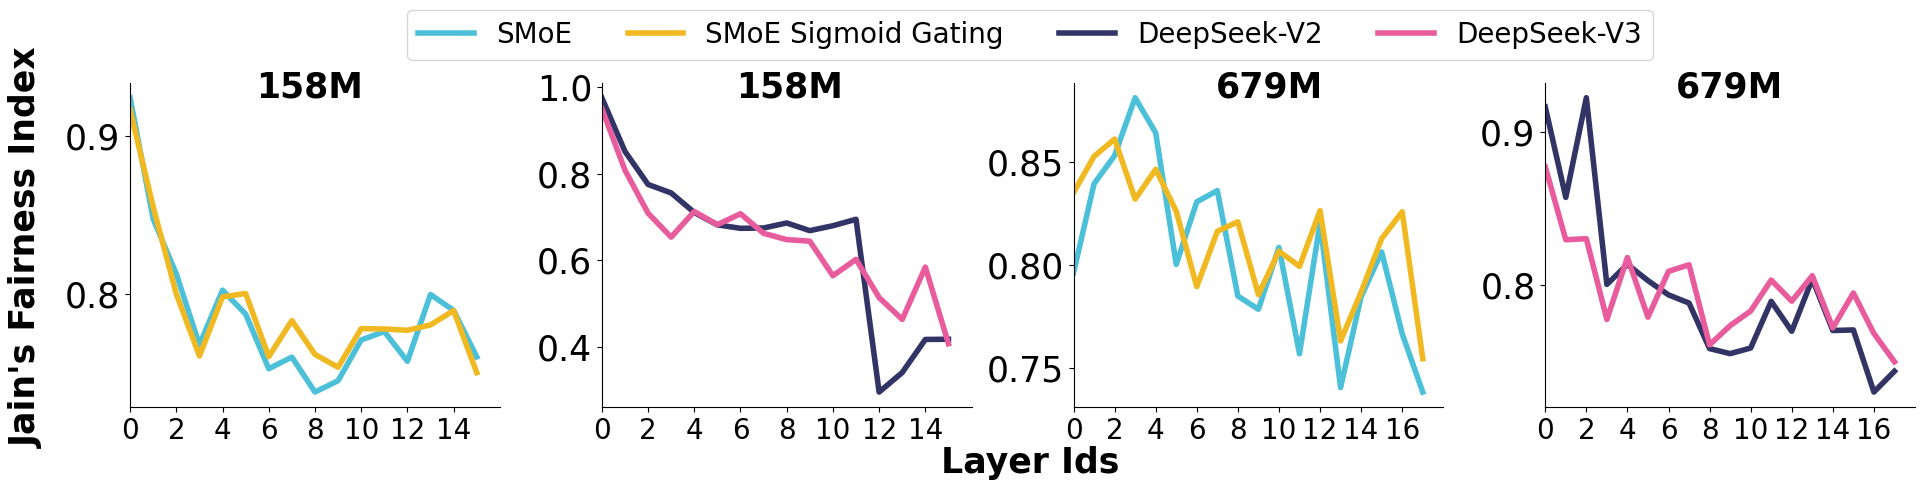

In [ ]:
colors = {
    "smoe": "#4bc0d8",
    "deepseek": "#e85b9c",
    "smoe_norm": "#f1b921",
    "deepseek_shared": "#313465",
}

fig, axs = plt.subplots(1, 4, figsize=(20, 4.5), sharex=False, sharey=False)

# Set shared labels
fig.text(0.55, 0.0, 'Layer Ids', ha='center', fontsize=25, weight='bold')
fig.text(0.04, 0.5, "Jain's Fairness Index", va='center', rotation='vertical', fontsize=25, weight='bold')

fig.text(0.19, 0.82, '158M', ha='center', va='bottom', fontsize=25, weight='bold')
fig.text(0.43, 0.82, '158M', ha='center', va='bottom', fontsize=25, weight='bold')

fig.text(0.67, 0.82, '679M', ha='center', va='bottom', fontsize=25, weight='bold')
fig.text(0.9, 0.82, '679M', ha='center', va='bottom', fontsize=25, weight='bold')

xlims = [(0, 16), (0, 16), (0, 18), (0, 18)]
xticks = [np.arange(0, 16, 2)] * 2 + [np.arange(0, 18, 2)] * 2

# For legend collection
lines = []
labels = []

for i, ax in enumerate(axs):
    if i == 0:
        l1, = ax.plot(range(16), result_158m["smoe"], linewidth=4, color='#4bc0d8')
        l2, = ax.plot(range(16), result_158m["smoe_sigmoid"], linewidth=4, color='#f1b921')
        lines.extend([l1, l2])
        labels.extend(["SMoE", "SMoE Sigmoid Gating"])
        # ax.set_title("158M", fontsize=30, weight='bold')
    elif i == 1:
        l3, = ax.plot(range(16), result_158m["smoe_shared"], linewidth=4, color='#313465')
        l4, = ax.plot(range(16), result_158m["smoe_deepseek"], linewidth=4, color='#e85b9c')
        lines.extend([l3, l4])
        labels.extend(["DeepSeek-V2", "DeepSeek-V3"])
        # ax.set_title("158M", fontsize=30, weight='bold')
    elif i == 2:
        ax.plot(range(18), result_679m["smoe"], linewidth=4, color='#4bc0d8')
        ax.plot(range(18), result_679m["smoe_sigmoid"], linewidth=4, color='#f1b921')
        # ax.set_title("679M", fontsize=30, weight='bold')
    elif i == 3:
        ax.plot(range(18), result_679m["smoe_shared"], linewidth=4, color='#313465')
        ax.plot(range(18), result_679m["smoe_deepseek"], linewidth=4, color='#e85b9c')
        # ax.set_title("679M", fontsize=30, weight='bold')

    ax.set_xticks(xticks[i])
    ax.set_xlim(xlims[i])
    
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=25)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

# Create a global legend in the right
fig.legend(lines, labels, loc='upper center', ncol=4, fontsize=20, bbox_to_anchor=(0.55, 1.06))

plt.tight_layout(rect=[0.06, 0.03, 1, 0.92])  # leave top 8% blank
plt.savefig('/home/fpt/moeut_training_code/paper/deepseek/results/jain_fairness_index/jain_fairness_index.pdf', format='pdf', bbox_inches='tight')
plt.show()

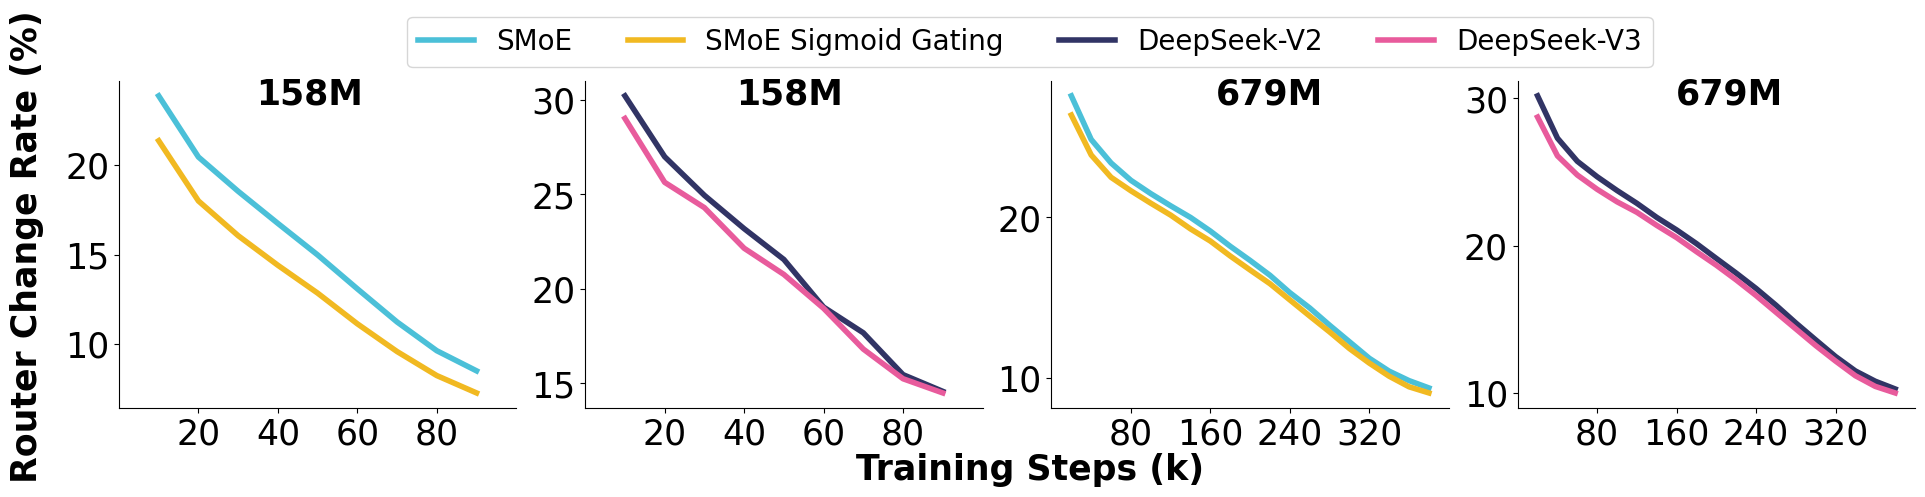

In [ ]:
smoe_158m = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_stability/158M/router_stability_smoe.csv").mean()
smoe_sigmoid_158m = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_stability/158M/router_stability_sigmoid.csv").mean()

smoe_shared_158m = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_stability/158M/router_stability_shared.csv").mean()
smoe_deepseek_158m = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_stability/158M/router_stability_deepseek.csv").mean()

smoe_679m = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_stability/679M/router_stability_smoe.csv").mean()
smoe_sigmoid_679m = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_stability/679M/router_stability_sigmoid.csv").mean()

smoe_shared_679m = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_stability/679M/router_stability_shared.csv").mean()
smoe_deepseek_679m = pd.read_csv("/home/fpt/moeut_training_code/paper/deepseek/router_stability/679M/router_stability_deepseek.csv").mean()

fig, axs = plt.subplots(1, 4, figsize=(20, 4.5), sharex=False, sharey=False)

# Set shared labels
# fig.text(0.5, 0.2, 'Training Steps (k)', ha='center', fontsize=25, weight='bold')
# fig.text(0.04, 0.68, 'Router Change Rate (%)', va='center', rotation='vertical', fontsize=25, weight='bold')

# Set shared labels
fig.text(0.55, 0., 'Training Steps (k)', ha='center', fontsize=25, weight='bold')
fig.text(0.04, 0.52, 'Router Change Rate (%)', va='center', rotation='vertical', fontsize=25, weight='bold')

fig.text(0.19, 0.82, '158M', ha='center', va='bottom', fontsize=25, weight='bold')
fig.text(0.43, 0.82, '158M', ha='center', va='bottom', fontsize=25, weight='bold')

fig.text(0.67, 0.82, '679M', ha='center', va='bottom', fontsize=25, weight='bold')
fig.text(0.9, 0.82, '679M', ha='center', va='bottom', fontsize=25, weight='bold')


xlims = [(0, 100), (0, 100), (0, 400), (0, 400)]
xticks = [np.arange(20, 100, 20)] * 2 + [np.arange(80, 400, 80)] * 2

# For legend collection
lines = []
labels = []

for i, ax in enumerate(axs):
    if i == 0:
        l1, = ax.plot(smoe_158m.index.astype(int) / 1000, smoe_158m.values, linewidth=4, color='#4bc0d8')
        l2, = ax.plot(smoe_sigmoid_158m.index.astype(int) / 1000, smoe_sigmoid_158m.values, linewidth=4, color='#f1b921')
        lines.extend([l1, l2])
        labels.extend(["SMoE", "SMoE Sigmoid Gating"])
        # ax.set_title("158M", fontsize=25, weight='bold')
    elif i == 1:
        l3, = ax.plot(smoe_shared_158m.index.astype(int) / 1000, smoe_shared_158m.values, linewidth=4, color='#313465')
        l4, = ax.plot(smoe_deepseek_158m.index.astype(int) / 1000, smoe_deepseek_158m.values, linewidth=4, color='#e85b9c')
        lines.extend([l3, l4])
        labels.extend(["DeepSeek-V2", "DeepSeek-V3"])
        # ax.set_title("158M", fontsize=25, weight='bold')
    elif i == 2:
        ax.plot(smoe_679m.index.astype(int) / 1000, smoe_679m.values, linewidth=4, color='#4bc0d8')
        ax.plot(smoe_sigmoid_679m.index.astype(int) / 1000, smoe_sigmoid_679m.values, linewidth=4, color='#f1b921')
        # ax.set_title("679M", fontsize=25, weight='bold')
    elif i == 3:
        ax.plot(smoe_shared_679m.index.astype(int) / 1000, smoe_shared_679m.values, linewidth=4, color='#313465')
        ax.plot(smoe_deepseek_679m.index.astype(int) / 1000, smoe_deepseek_679m.values, linewidth=4, color='#e85b9c')
        # ax.set_title("679M", fontsize=25, weight='bold')

    ax.set_xticks(xticks[i])
    ax.set_xlim(xlims[i])
    
    ax.xaxis.set_tick_params(labelsize=25)
    ax.yaxis.set_tick_params(labelsize=25)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


# Create a global legend in the right
fig.legend(lines, labels, loc='upper center', ncol=4, fontsize=20, bbox_to_anchor=(0.55, 1.06))

# plt.tight_layout(rect=[0.06, 0.25, 1, 1.3])  # adjust bottom for legend space
plt.tight_layout(rect=[0.06, 0.03, 1, 0.92])  # leave top 8% blank
plt.savefig('/home/fpt/moeut_training_code/paper/deepseek/results/router_change_rate/router_change_rate.pdf', format='pdf', bbox_inches='tight')
plt.show()